In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os.path

from os import getcwd
import numpy as np
import pandas as pd
import hdf5storage
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import savemat, loadmat
import math
from scipy.fftpack import fft, ifft
from scipy.stats import zscore, f_oneway
#import samplerate
import multiprocessing as mp
from scipy.signal import resample
import random
import pyreadr
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score
import statsmodels.api as sm
import scipy
import matplotlib.patches as mpatches
import statsmodels.stats.multitest as multitest
import mne
from mne.preprocessing import ICA
from mne.time_frequency import tfr_morlet
from sklearn.metrics import r2_score


In [2]:
def get_info(field_num):
    field = []
    for item in range(trial_num):
        field.append(group_data['DATA'][0][item][field_num][0])
    return pd.DataFrame(field)

def load_time_series(subject, session, unit_id):
    #subj_mat = hdf5storage.loadmat(f"Z:\DBS\\{subject}\Preprocessed Data\SpikeSorting\\{subject}_ft_raw_spike.mat")
    subj_mat = hdf5storage.loadmat(f"/Volumes/Nexus/DBS/{subject}/Preprocessed Data/SpikeSorting/{subject}_ft_raw_spike.mat")
    time_data = subj_mat['IFR'][0]['time'][0][int(session-1)][0]
    neural_data = subj_mat['IFR'][0]['trial'][0][int(session-1)][int(unit_id-1)]
    
    time_data = time_data[~np.isnan(neural_data)]
    neural_data = neural_data[~np.isnan(neural_data)]
    
    return time_data, neural_data

def get_df(time_point, neural_data, time_data, after=3.5, before=1.5, fs=1000):
    dfs = []
    time_point = time_point[time_point<time_data.max()-2][time_point>time_data.min()+2]
    for item in time_point:
        for i2 in range(len(neural_data)):
            if time_data[i2] > item:
                dfs.append(neural_data[i2-int(before*fs):i2+int(after*fs)])
                break
    return np.array(dfs)

# function to convert to superscript
def get_super(x):
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    super_s = "ᴬᴮᶜᴰᴱᶠᴳᴴᴵᴶᴷᴸᴹᴺᴼᴾQᴿˢᵀᵁⱽᵂˣʸᶻᵃᵇᶜᵈᵉᶠᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘᵛʷˣʸᶻ⁰¹²³⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾"
    res = x.maketrans(''.join(normal), ''.join(super_s))
    return x.translate(res)

In [3]:

#group_data = hdf5storage.loadmat(r"Z:\Commits\DBS_speech\Dev\U01SpikeAnalysis\data\group_data\group_data_narrow_09082021.mat")
#group_data = hdf5storage.loadmat(r"../../../../Macintosh HD/Users/yanming/Desktop/MGH BML/Sound-induced_STN_activity/manuscript/group_data_narrow_09082021.mat")
group_data = hdf5storage.loadmat(r"../../../../Macintosh HD/Users/yanming/Desktop/stn_auditory/group_data_narrow_09082021.mat")

trial_num = len(group_data['DATA'][0])

SubjectID = get_info(0)
SubjectID.columns = ['SubjectID']

session = get_info(1)
session.columns = ['session']

electrode = get_info(2)
electrode.columns = ['electrode']

unit_id = get_info(3)
unit_id.columns = ['unit_id']

unit = get_info(4)
unit.columns = ['unit']

RecType = get_info(5)
RecType.columns = ['RecType']

grade = get_info(6)
grade.columns = ['grade']

info = pd.concat([SubjectID, session, electrode, unit_id, unit, RecType, grade], axis=1)
info.head(2)
info.shape

,SubjectID,session,electrode,unit_id,unit,RecType,grade
0,DBS3001,1,micro_m,6,4,MU,B
1,DBS3001,2,micro_c,7,1,MU,C


(229, 7)

In [4]:
def get_produced_freq():
    produced_freq = pd.read_csv('all_freq.csv', index_col='id')
    d = {'ah':0, 'oo':1, 'ee':2}
    produced_freq['stim_factor'] = produced_freq.stim.map(d)
    produced_freq['spl'] = 20*np.log10(produced_freq['rms_audio_p'])
    produced_freq = produced_freq.dropna().reset_index(drop=1)

    produced_freq['before_time'] = np.nan
    for item in range(1, produced_freq.shape[0]):
        if produced_freq.syl_id[item] == 2:
            if produced_freq.syl_id[item-1] == 1:
                produced_freq.before_time[item] = produced_freq.starts[item] - produced_freq.ends[item-1]
        elif produced_freq.syl_id[item] == 3:
            if produced_freq.syl_id[item-1] == 2:
                produced_freq.before_time[item] = produced_freq.starts[item] - produced_freq.ends[item-1]

    for item in range(1, produced_freq.shape[0]):
        if produced_freq.syl_id[item] == 1:
            if produced_freq.syl_id[item+1] == 2:
                if produced_freq.syl_id[item+2] == 3:
                    produced_freq.before_time[item] = (produced_freq.before_time[item+1] + 
                                                       produced_freq.before_time[item+2])/2

    produced_freq.before_time[0] = (produced_freq.before_time[1] + produced_freq.before_time[2])/2
    produced_freq = produced_freq.dropna().reset_index(drop=1)
    return produced_freq

produced_df = get_produced_freq()
produced_df.shape
produced_df.head(2)

(41210, 26)

,starts,ends,duration,cons_onset,trial_id,session_id,syl_id,channel,fundamental_freq,type,...,subject,freq2,discont,contrun_id,t,t2,t3,stim_factor,spl,before_time
0,36145.009713,36145.184457,0.174745,36145.009713,1,1,1,audio_p,142.196732,vowel,...,DBS3001,20219.910530,1,1,-195.420094,38189.013071,-7.462901e+06,0,-18.178208,0.404081
1,36145.494905,36145.643055,0.148150,36145.494905,1,1,2,audio_p,140.861581,vowel,...,DBS3001,19841.984898,0,1,-194.934901,37999.615755,-7.407451e+06,1,-21.894791,0.310448


In [5]:
def get_subj_table(produced_freq, number_elec, info, timing_subj, neural_subj):
    SUBJ = info.iloc[number_elec, 0]
    SESS = info.iloc[number_elec, 1]
    subj_table = produced_freq[produced_freq.subject == SUBJ].reset_index(drop=1)
    subj_table = subj_table[subj_table.session_id == SESS].reset_index(drop=1)
    subj_table = subj_table[subj_table.starts > timing_subj.min()+3.5].reset_index(drop=1)
    subj_table = subj_table[subj_table.starts < timing_subj.max()-3.5].reset_index(drop=1)

        
    subj_table['avg_spike'] = np.nan
    for trial in range(subj_table.shape[0]):
        if subj_table.ends[trial] < timing_subj.max() - 3.5:
            if subj_table.starts[trial] > timing_subj.min() + 3.5:
                subj_table.avg_spike[trial] = get_avg_spike(subj_table.iloc[trial], 
                                                            neural_subj, timing_subj)
    subj_table = subj_table.dropna(0).reset_index(drop=1)
    
    subj_table['t_z'] = (subj_table['t'] - subj_table['t'].mean())/subj_table['t'].std(ddof=0)
    stim_vol_mean = subj_table['stim_volume'].mean()
    subj_table['stim_vol_z'] = (subj_table['stim_volume'] - 
                                   stim_vol_mean)/subj_table['stim_volume'].std(ddof=0)
    if subj_table['stim_volume'].unique().shape[0]==1:
        subj_table['stim_vol_z'] = 0
        

    subj_table['syl_id_z'] = (subj_table['syl_id'] - 
                              subj_table['syl_id'].mean())/subj_table['syl_id'].std(ddof=0)
    subj_table['spl_z'] = (subj_table['spl'] - 
                           subj_table['spl'].mean())/subj_table['spl'].std(ddof=0)
    stim_fac_mean = subj_table['stim_factor'].mean()
    subj_table['stim_z'] = (subj_table['stim_factor'] - 
                                   stim_fac_mean)/subj_table['stim_factor'].std(ddof=0)
    fund_freq_mean = subj_table['fundamental_freq'].mean()
    subj_table['pitch_z'] = (subj_table['fundamental_freq'] - 
                             fund_freq_mean)/subj_table['fundamental_freq'].std(ddof=0)
    subj_table['pitch_spl_z'] = subj_table['pitch_z']*subj_table['spl_z']

    return subj_table

In [6]:
def get_subj_df_cue(subject, sess, subj_table):
    #cue_df = pd.read_csv(f'Z:\DBS\\{subject}\Preprocessed Data\Sync\\annot\\{subject}_stimulus_syllable.txt', sep='	', index_col='id')
    cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{subject}/Preprocessed Data/Sync/annot/{subject}_stimulus_syllable.txt', sep='	', index_col='id')
    cue_df = cue_df[cue_df['session_id']==sess].reset_index(drop=1)
    subj_table_cue = pd.merge(subj_table, cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")
    return subj_table_cue

def find_rest_time(subject_df):
    resting_time = subject_df[subject_df['syl_id'] == 1]['starts_y'] - 1
    return resting_time

def nansem(a, axis=1):
    return np.nanstd(a, axis=0)/np.sqrt(a.shape[axis])

def find_full_3_trial(subj_table, timing_subj):
    good_trial = []
    subj_table = subj_table.dropna()
    subj_table = subj_table[subj_table['starts_y'] > timing_subj.min() + 3.5]
    subj_table = subj_table[subj_table['ends_x'] < timing_subj.max() - 3.5]
    for item in subj_table['trial_id'].unique():
        if subj_table[subj_table['trial_id'] == item].shape[0] == 3:
            good_trial.append(item)
    return subj_table[subj_table['trial_id'].isin(good_trial)]

In [7]:
def get_avg_spike(time_table, neural_data, time_data, fs=1000):
    time_point = time_table['starts']
    before = time_table['before_time']
    after = time_table['duration']
    dfs = []

    for item in range(len(neural_data)):
        if time_data[item] > time_point:
            dfs.append(neural_data[item-int(before*fs):item+int(after*fs)])
            break
    return np.mean(np.array(dfs))

In [8]:
def nansem(a, axis=1):
    return np.nanstd(a, axis=0)/np.sqrt(a.shape[axis])

In [9]:
def get_zscore(input_mat):
    rest_mat = input_mat[:, :500]
    input_mat_z = np.zeros(input_mat.shape)
    for item in range(rest_mat.shape[0]):
        rest_mean = rest_mat[item].mean()
        rest_sd = np.nanstd(rest_mat[item])
        input_mat_z[item] = (input_mat[item] - rest_mean)/rest_sd
    return input_mat_z

In [10]:
def get_avg_activity_cue(number_elec):
    SUBJECT = info.iloc[number_elec, 0]
    session = info.iloc[number_elec, 1]
    contact = info.iloc[number_elec, 3]
    
    timing, neural_df = load_time_series(SUBJECT, session, contact)
    subj_df = get_subj_table(produced_df, number_elec, info, timing, neural_df)
    subj_df_cue = get_subj_df_cue(SUBJECT, session, subj_df)
    subj_df_cue = find_full_3_trial(subj_df_cue, timing)
    cue_start_1 = subj_df_cue[subj_df_cue['syl_id'] == 1]['starts_y']
    cue_start_all = subj_df_cue['starts_y']
    
    spike_mat_1 = get_df(cue_start_1, neural_df, timing, after=3.5, before=1.5)
    #spike_mat_1 = get_zscore(spike_mat_1)
    spike_mat_1_sem = nansem(spike_mat_1)
    spike_mat_1 = np.nanmean(spike_mat_1, axis=0)
    
    spike_mat_all = get_df(cue_start_all, neural_df, timing, after=3.5, before=1.5)
    #spike_mat_all = get_zscore(spike_mat_all)
    spike_mat_all_sem = nansem(spike_mat_all)
    spike_mat_all = np.nanmean(spike_mat_all, axis=0)
    
    return spike_mat_1, spike_mat_1_sem, spike_mat_all, spike_mat_all_sem

In [11]:
def get_avg_activity_speech(number_elec):
    SUBJECT = info.iloc[number_elec, 0]
    session = info.iloc[number_elec, 1]
    contact = info.iloc[number_elec, 3]
    
    timing, neural_df = load_time_series(SUBJECT, session, contact)
    subj_df = get_subj_table(produced_df, number_elec, info, timing, neural_df)
    subj_df_cue = get_subj_df_cue(SUBJECT, session, subj_df)
    subj_df_cue = find_full_3_trial(subj_df_cue, timing)
    produced_start_1 = subj_df_cue[subj_df_cue['syl_id'] == 1]['starts_x']
    produced_start_all = subj_df_cue['starts_x']
    
    spike_mat_1 = get_df(produced_start_1, neural_df, timing, after=3.5, before=1.5)
    #spike_mat_1 = get_zscore(spike_mat_1)
    spike_mat_1_sem = nansem(spike_mat_1)
    spike_mat_1 = np.nanmean(spike_mat_1, axis=0)
    
    spike_mat_all = get_df(produced_start_all, neural_df, timing, after=3.5, before=1.5)
    #spike_mat_all = get_zscore(spike_mat_all)
    spike_mat_all_sem = nansem(spike_mat_all)
    spike_mat_all = np.nanmean(spike_mat_all, axis=0)
    
    return spike_mat_1, spike_mat_1_sem, spike_mat_all, spike_mat_all_sem

In [12]:
def find_full_3_trial2(subj_table):
    good_trial = []
    num_sess = len(subj_table['session_id'].unique())
    for item in subj_table['trial_id'].unique():
        if subj_table[subj_table['trial_id'] == item].shape[0]/num_sess == 3:
            good_trial.append(item)
    return subj_table[subj_table['trial_id'].isin(good_trial)]
from scipy.signal import hilbert, chirp
import matplotlib.patches as mpatches
import statsmodels.stats.multitest as multitest

In [13]:
cue_ecog = pd.read_csv('ecog_cue.csv').iloc[:, :4]
cue_ecog_neg = cue_ecog[cue_ecog['dir'] == "-"]
cue_ecog = cue_ecog[cue_ecog['dir'] == "+"]
cue_ecog_onset = cue_ecog[cue_ecog['type'] == "Onset"]
cue_ecog_sus = cue_ecog[cue_ecog['type'] == "Sus"]
cue_ecog_three = cue_ecog[cue_ecog['type'] == "Three"]

In [14]:
ecog_hg_time = loadmat("processed_data/ecog_hg_time.mat")
ecog_hg_onset_mean = ecog_hg_time['ecog_hg_onset_mean']
ecog_hg_sus_mean = ecog_hg_time['ecog_hg_sus_mean']
ecog_hg_three_mean = ecog_hg_time['ecog_hg_three_mean']

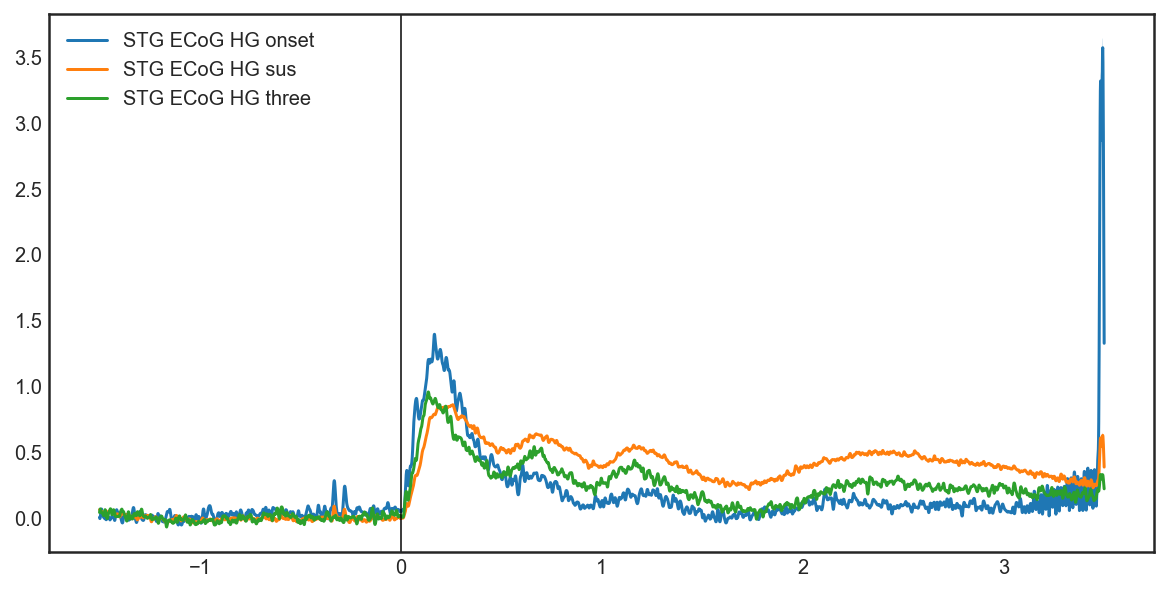

In [22]:
xvals = np.linspace(-1.5, 3.5, 5000)

fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 4))

mean = ecog_hg_onset_mean.mean(axis=0)
sem = nansem(ecog_hg_onset_mean, axis=1)
axs.plot(xvals, mean, label='STG ECoG HG onset')
axs.fill_between(xvals, mean-sem, mean+sem, alpha=0.5)

mean = ecog_hg_sus_mean.mean(axis=0)
sem = nansem(ecog_hg_sus_mean, axis=1)
axs.plot(xvals, mean, label='STG ECoG HG sus')
axs.fill_between(xvals, mean-sem, mean+sem, alpha=0.5)

mean = ecog_hg_three_mean.mean(axis=0)
sem = nansem(ecog_hg_three_mean, axis=1)
axs.plot(xvals, mean, label='STG ECoG HG three')
axs.fill_between(xvals, mean-sem, mean+sem, alpha=0.5)

axs.axvline(0, color='k', linewidth=0.75)

plt.legend()
plt.show();

In [9]:
elec_mat = {'elec_mat_2':elec_mat_2, 'elec_mat_1':elec_mat_1}

savemat('processed_data/lfp_beta_suppression', elec_mat)

NameError: name 'elec_mat_2' is not defined

In [10]:
SUBJECT = "DBS3003"
elec = 2

f_range = (70, 150)
#file_path = f'..\..\..\DBS\\{SUBJECT}\Preprocessed Data\FieldTrip'
#subj_mat = hdf5storage.loadmat(f"{file_path}\\{SUBJECT}_ft_raw_filt_trial_denoised.mat")['D'][0]
file_path = f'../../../DBS/{SUBJECT}/Preprocessed Data/FieldTrip'
subj_mat = hdf5storage.loadmat(f"{file_path}/{SUBJECT}_ft_raw_filt_trial_denoised.mat")['D'][0]

chanlabel = []
for item in range(subj_mat['label'].shape[0]):
    chanlabel.append(subj_mat['label'][item][0][0][0])
chanlabel = np.array(chanlabel)

fs = subj_mat['fsample'][0][0]
nChans = len(subj_mat['label'])
nTrials = len(subj_mat['trial'][0])

ecog_chan = []
for item in range(nChans):
    if chanlabel[item][:4] == "ecog":
        ecog_chan.append(item)

time_mat = subj_mat['time'][0]
trial_mat = subj_mat['trial'][0]

subject_table = produced_df[produced_df.subject == SUBJECT].reset_index(drop=1)
subject_table = find_full_3_trial2(subject_table).reset_index(drop=1)
subject_table = subject_table[subject_table.syl_id == 1].reset_index(drop=1)

NameError: name 'produced_df' is not defined

In [15]:
#cue_df = pd.read_csv(f'Z:\DBS\\{SUBJECT}\Preprocessed Data\Sync\\annot\\{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{SUBJECT}/Preprocessed Data/Sync/annot/{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')

subj_df_cue = pd.merge(subject_table, cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

ecog_mat = np.zeros((subj_df_cue.shape[0], 5000))

for item in range(subj_df_cue.shape[0]):
    time_point = subj_df_cue.iloc[item].starts_y
    for i2 in range(nTrials):
        time_min = time_mat[i2][0].min()
        time_max = time_mat[i2][0].max()
        if (time_point < time_max - 3.5) and (time_point > time_min + 1.5):
            for i3 in range(len(time_mat[i2][0])):
                if time_mat[i2][0][i3] > time_point:
                    if len(ecog_chan)> 0:
                        sig_filt = trial_mat[i2][ecog_chan][elec]
                        sig_filt = filter_signal(sig_filt, fs, 'bandpass', f_range)
                        sig_filt = np.nan_to_num(sig_filt)
                        analytic_signal = hilbert(sig_filt)
                        amplitude_envelope = np.abs(analytic_signal)
                        ecog_mat[item] = amplitude_envelope[i3-1500:i3+3500]


                    break
                    break

elec_mat = ecog_mat[~np.all(ecog_mat == 0, axis=1)]
elec_mat = get_zscore(elec_mat)
elec_mat_sem = nansem(elec_mat)
#elec_mat = np.nanmean(elec_mat, axis=0)

NameError: name 'SUBJECT' is not defined

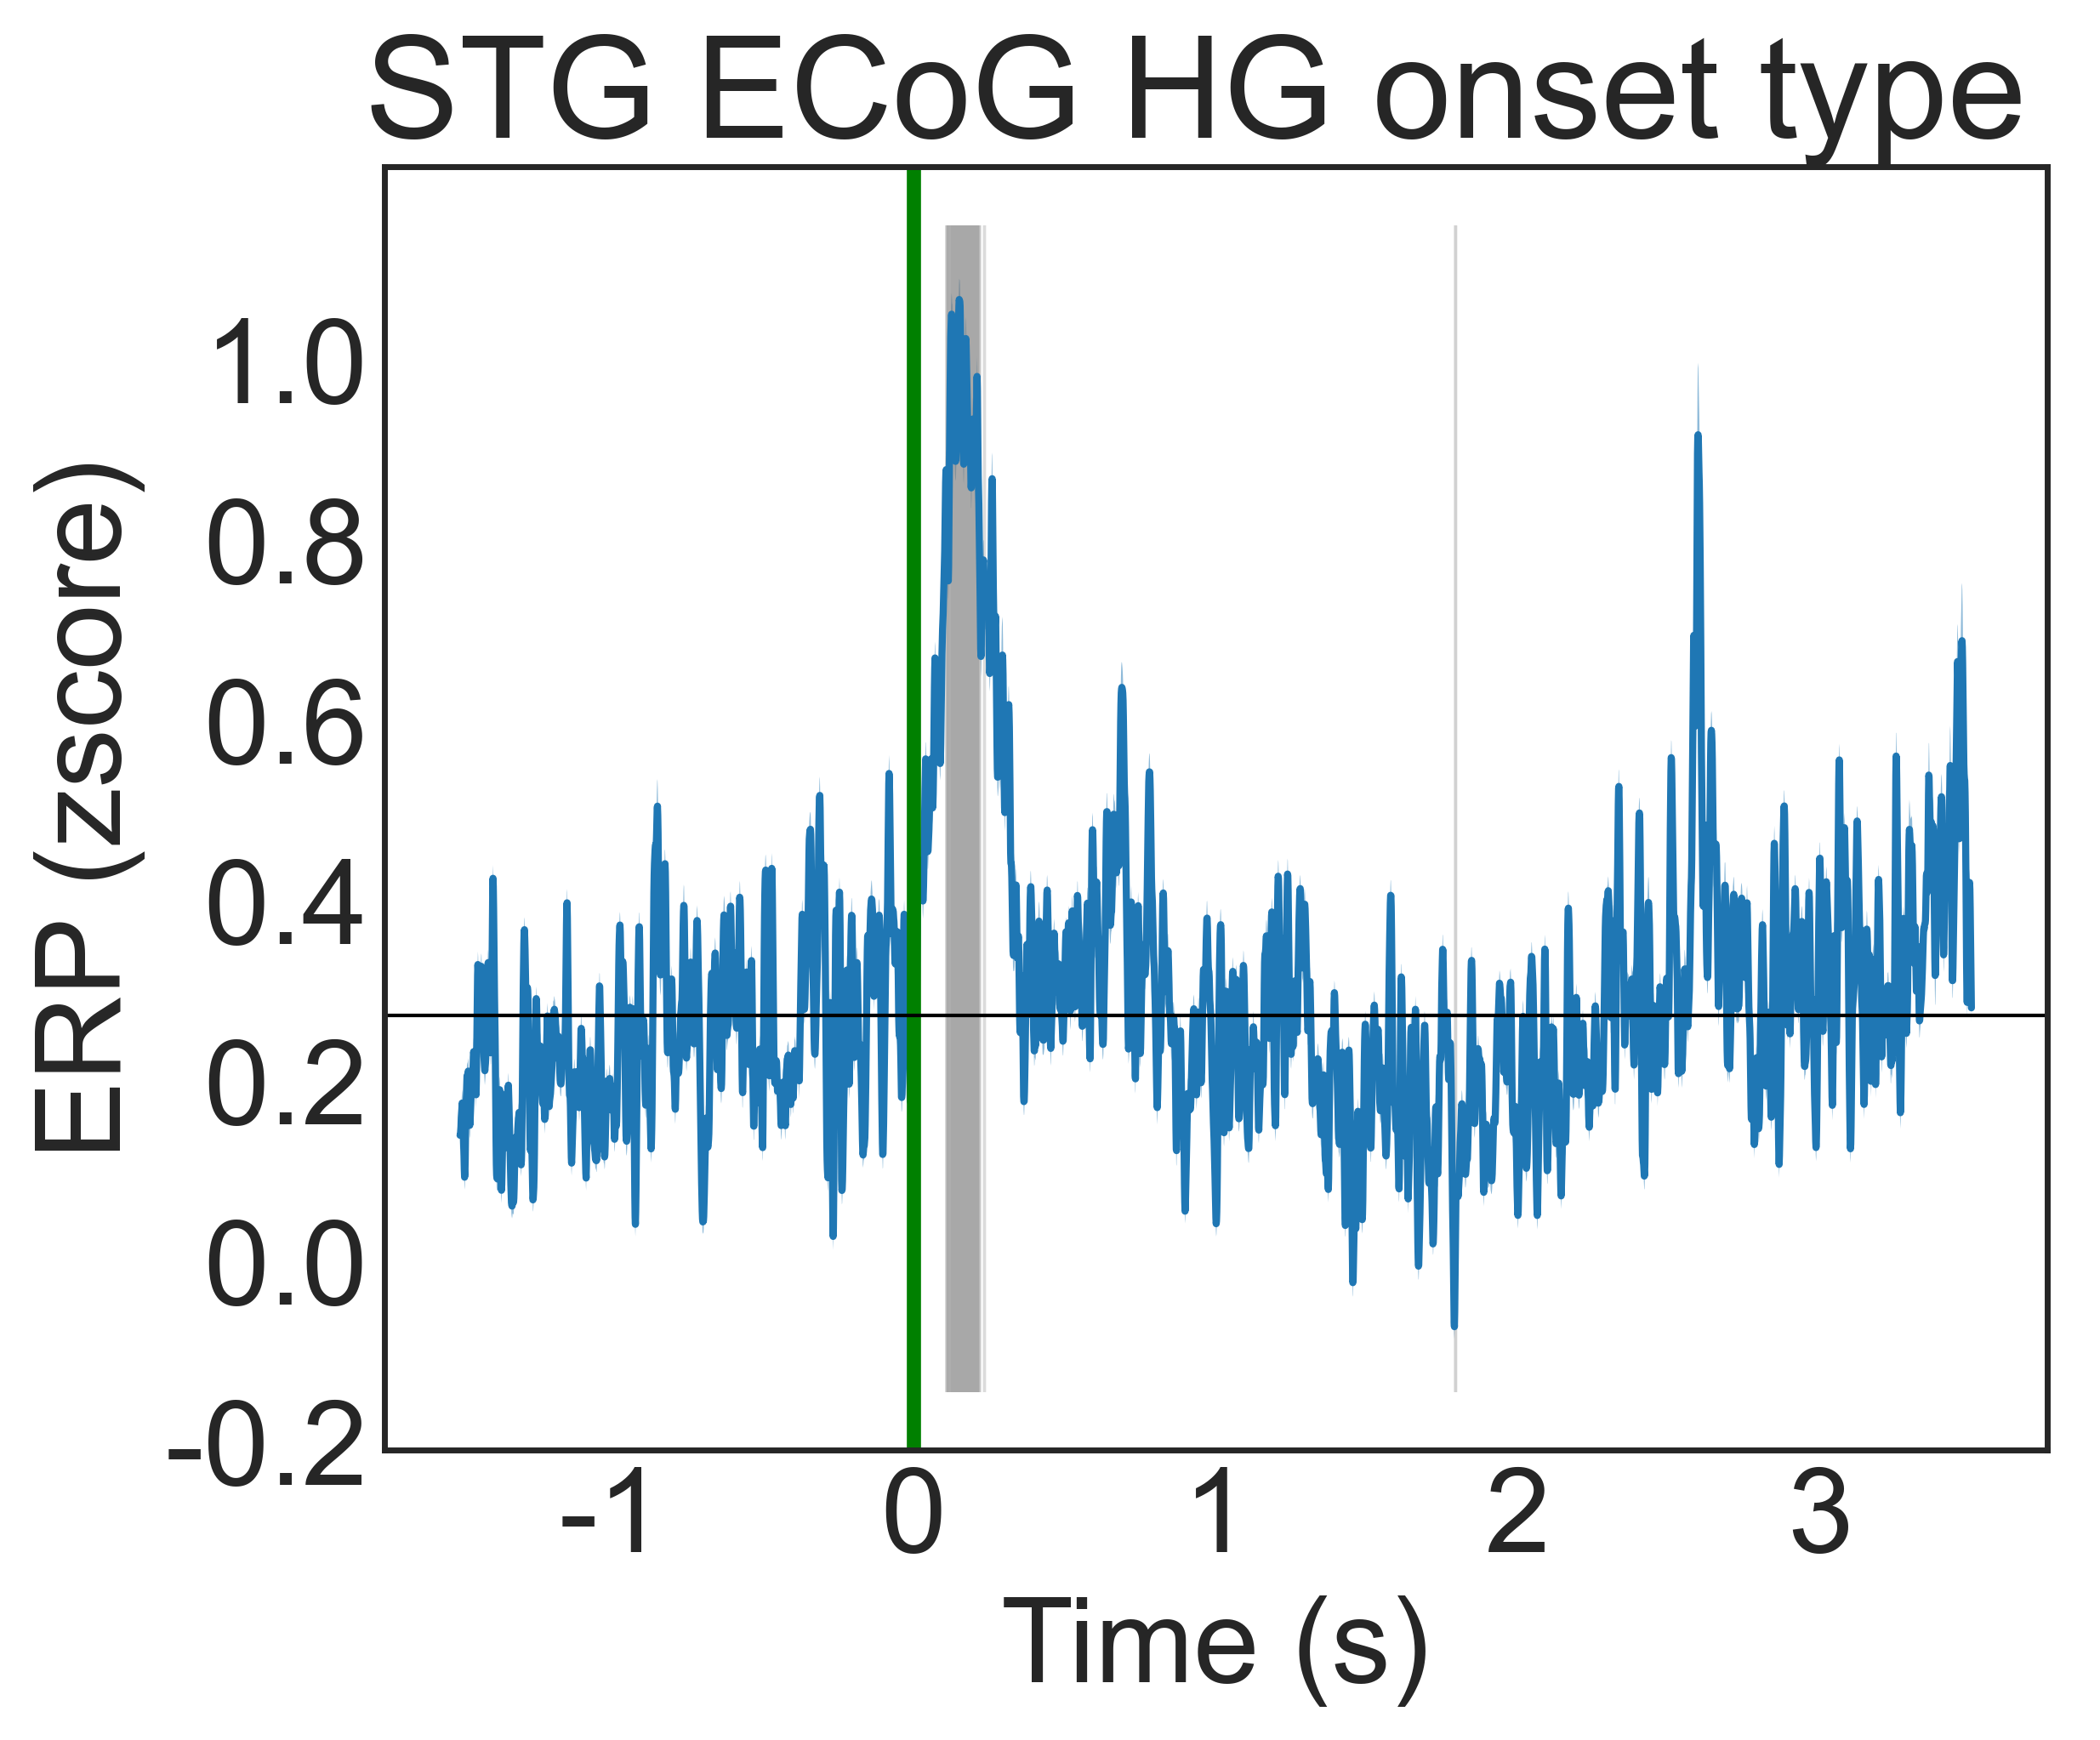

In [23]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 5), dpi=200)
axs.patch.set_alpha(0)

elec_mat_mean = np.nanmean(elec_mat, axis=0)
axs.plot(xvals, elec_mat_mean)
axs.fill_between(xvals, elec_mat_mean-elec_mat_sem, elec_mat_mean+elec_mat_sem, alpha=0.5)
axs.set_title(f"STG ECoG HG onset type ", fontsize=30)
FR_mean = elec_mat_mean[500:1500].mean()
FR_std = np.nanstd(elec_mat_mean[500:1500])
FR_compare = FR_std * np.random.randn(100, 5000) + FR_mean

axs.axvline(0, color='g', linewidth=3)
axs.axhline(FR_mean, color='k', linewidth=0.75, label='Mean ERP amplitude')
axs.set_ylabel('ERP (zscore)', fontsize=25)
axs.set_xlabel('Time (s)', fontsize=25)

significance = pd.DataFrame({"xvals":xvals, 
                             "pval":f_oneway(elec_mat, FR_compare).pvalue})
patch_y = axs.get_ylim()[1] - axs.get_ylim()[0]
for item in range(len(xvals)):
    if multitest.fdrcorrection(significance.pval)[0][item] == True:
        axs.add_patch(mpatches.Rectangle((item/1000-1.5, 
                                                   axs.get_ylim()[0]), 
                                                  0.01, patch_y, color='grey', 
                                                  alpha=0.1, ec=None))
        
axs.set_xticklabels(axs.get_xticks().astype(int), fontsize=25)
axs.set_yticklabels([round(item, 2) for item in axs.get_yticks()], fontsize=25)
plt.plot();

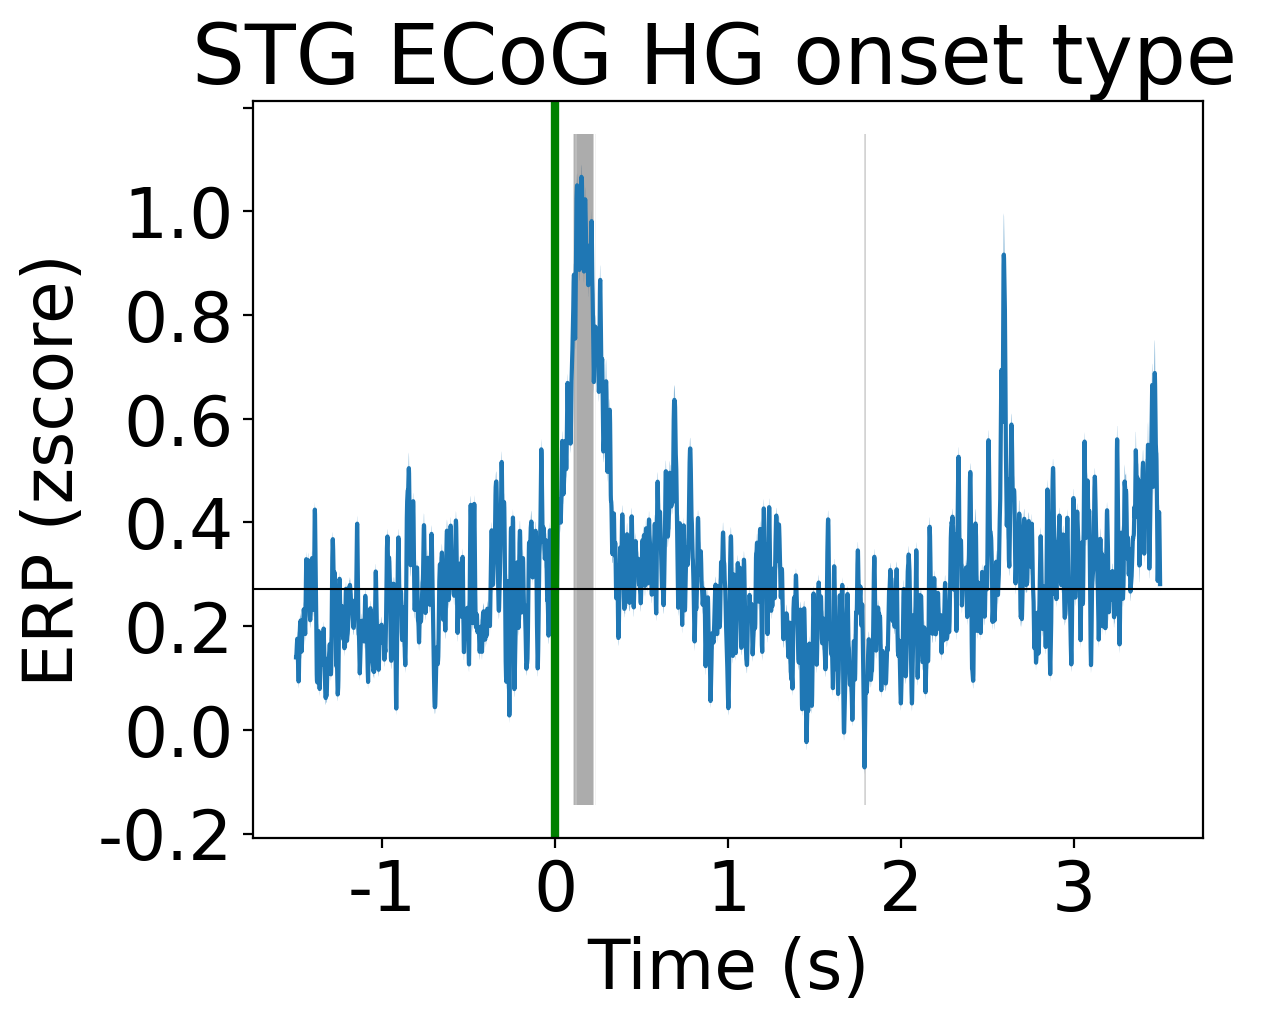

In [56]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 5), dpi=200)
axs.patch.set_alpha(0)

elec_mat_mean = np.nanmean(elec_mat, axis=0)
axs.plot(xvals, elec_mat_mean)
axs.fill_between(xvals, elec_mat_mean-elec_mat_sem, elec_mat_mean+elec_mat_sem, alpha=0.5)
axs.set_title(f"STG ECoG HG onset type ", fontsize=30)
FR_mean = elec_mat_mean[500:1500].mean()
FR_std = np.nanstd(elec_mat_mean[500:1500])
FR_compare = FR_std * np.random.randn(100, 5000) + FR_mean

axs.axvline(0, color='g', linewidth=3)
axs.axhline(FR_mean, color='k', linewidth=0.75, label='Mean ERP amplitude')
axs.set_ylabel('ERP (zscore)', fontsize=25)
axs.set_xlabel('Time (s)', fontsize=25)

significance = pd.DataFrame({"xvals":xvals, 
                             "pval":f_oneway(elec_mat, FR_compare).pvalue})
patch_y = axs.get_ylim()[1] - axs.get_ylim()[0]
for item in range(len(xvals)):
    if multitest.fdrcorrection(significance.pval)[0][item] == True:
        axs.add_patch(mpatches.Rectangle((item/1000-1.5, 
                                                   axs.get_ylim()[0]), 
                                                  0.01, patch_y, color='grey', 
                                                  alpha=0.1, ec=None))
        
axs.set_xticklabels(axs.get_xticks().astype(int), fontsize=25)
axs.set_yticklabels([round(item, 2) for item in axs.get_yticks()], fontsize=25)
plt.plot();

In [16]:

#print(i2)
SUBJECT = "DBS3008"
elec = 0

f_range = (13, 30)
#file_path = f'..\..\..\DBS\\{SUBJECT}\Preprocessed Data\FieldTrip'
#subj_mat = hdf5storage.loadmat(f"{file_path}\\{SUBJECT}_ft_raw_filt_trial_denoised.mat")['D'][0]
file_path = f'../../../DBS/{SUBJECT}/Preprocessed Data/FieldTrip'
subj_mat = hdf5storage.loadmat(f"{file_path}/{SUBJECT}_ft_raw_filt_trial_denoised.mat")['D'][0]

chanlabel = []
for item in range(subj_mat['label'].shape[0]):
    chanlabel.append(subj_mat['label'][item][0][0][0])
chanlabel = np.array(chanlabel)

fs = subj_mat['fsample'][0][0]
nChans = len(subj_mat['label'])
nTrials = len(subj_mat['trial'][0])

dbs_chan = []
for item in range(nChans):
    if chanlabel[item][:4] == "dbs_":
        dbs_chan.append(item)

time_mat = subj_mat['time'][0]
trial_mat = subj_mat['trial'][0]

subject_table = produced_df[produced_df.subject == SUBJECT].reset_index(drop=1)
subject_table = find_full_3_trial2(subject_table).reset_index(drop=1)
subject_table = subject_table[subject_table.syl_id == 1].reset_index(drop=1)

#cue_df = pd.read_csv(f'Z:\DBS\\{SUBJECT}\Preprocessed Data\Sync\\annot\\{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{SUBJECT}/Preprocessed Data/Sync/annot/{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
subj_df_cue = pd.merge(subject_table, cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

ecog_mat = np.zeros((subj_df_cue.shape[0], 5000))

for item in range(subj_df_cue.shape[0]):
    time_point = subj_df_cue.iloc[item].starts_y
    for i2 in range(nTrials):
        time_min = time_mat[i2][0].min()
        time_max = time_mat[i2][0].max()
        if (time_point < time_max - 3.5) and (time_point > time_min + 1.5):
            for i3 in range(len(time_mat[i2][0])):
                if time_mat[i2][0][i3] > time_point:
                    if len(dbs_chan)> 0:
                        sig_filt = trial_mat[i2][dbs_chan][elec]
                        sig_filt = filter_signal(sig_filt, fs, 'bandpass', f_range)
                        sig_filt = np.nan_to_num(sig_filt)
                        analytic_signal = hilbert(sig_filt)
                        amplitude_envelope = np.abs(analytic_signal)
                        ecog_mat[item] = amplitude_envelope[i3-1500:i3+3500]


                    break
                    break

elec_mat = ecog_mat[~np.all(ecog_mat == 0, axis=1)]
elec_mat = get_zscore(elec_mat)
#elec_mat = np.nanmean(elec_mat, axis=0)
elec_mat_1 = elec_mat

KeyError: 'D'

In [18]:
SUBJECT = "DBS3008"
elec = 0

f_range = (13, 30)
#file_path = f'..\..\..\DBS\\{SUBJECT}\Preprocessed Data\FieldTrip'
#subj_mat = hdf5storage.loadmat(f"{file_path}\\{SUBJECT}_ft_raw_filt_trial_denoised.mat")['D'][0]
file_path = f'../../../DBS/{SUBJECT}/Preprocessed Data/FieldTrip'
subj_mat = hdf5storage.loadmat(f"{file_path}/{SUBJECT}_ft_raw_filt_trial_denoised.mat")['D'][0]

In [19]:
chanlabel = []
for item in range(subj_mat['label'].shape[0]):
    chanlabel.append(subj_mat['label'][item][0][0][0])
chanlabel = np.array(chanlabel)

fs = subj_mat['fsample'][0][0]
nChans = len(subj_mat['label'])
nTrials = len(subj_mat['trial'][0])

dbs_chan = []
for item in range(nChans):
    if chanlabel[item][:4] == "dbs_":
        dbs_chan.append(item)

time_mat = subj_mat['time'][0]
trial_mat = subj_mat['trial'][0]

subject_table = produced_df[produced_df.subject == SUBJECT].reset_index(drop=1)
subject_table = find_full_3_trial2(subject_table).reset_index(drop=1)
subject_table = subject_table[subject_table.syl_id == 1].reset_index(drop=1)

#cue_df = pd.read_csv(f'Z:\DBS\\{SUBJECT}\Preprocessed Data\Sync\\annot\\{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{SUBJECT}/Preprocessed Data/Sync/annot/{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
subj_df_cue = pd.merge(subject_table, cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

ecog_mat = np.zeros((subj_df_cue.shape[0], 5000))

for item in range(subj_df_cue.shape[0]):
    time_point = subj_df_cue.iloc[item].starts_y
    for i2 in range(nTrials):
        time_min = time_mat[i2][0].min()
        time_max = time_mat[i2][0].max()
        if (time_point < time_max - 3.5) and (time_point > time_min + 1.5):
            for i3 in range(len(time_mat[i2][0])):
                if time_mat[i2][0][i3] > time_point:
                    if len(dbs_chan)> 0:
                        good_trial = trial_mat[i2][dbs_chan][elec]
                        ecog_mat[item] = good_trial[i3-1500:i3+3500]


                    break
                    break
                    
elec_mat = ecog_mat[~np.all(ecog_mat == 0, axis=1)]


In [20]:
trial_mat.shape
elec_mat.shape
time_mat.shape

(358,)

(110, 5000)

(358,)

In [21]:
time_mat[0].shape

(1, 13463)

In [18]:
tf_mat = np.expand_dims(elec_mat, axis=1)
tf_mat = mne.EpochsArray(tf_mat, mne.create_info([f'{chanlabel}'], 1000))
freqs = np.logspace(*np.log10([10, 150]), num=49)
n_cycles = freqs / 2.
power, itc = tfr_morlet(tf_mat, freqs=freqs, n_cycles=n_cycles, picks='all')
times = np.linspace(0, 5, 5000)
extent = (times[0], times[-1], freqs[0], freqs[-1])
power_rescale = mne.baseline.rescale(power.data[0], tf_mat.times, (0.5, 1))

Not setting metadata
110 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


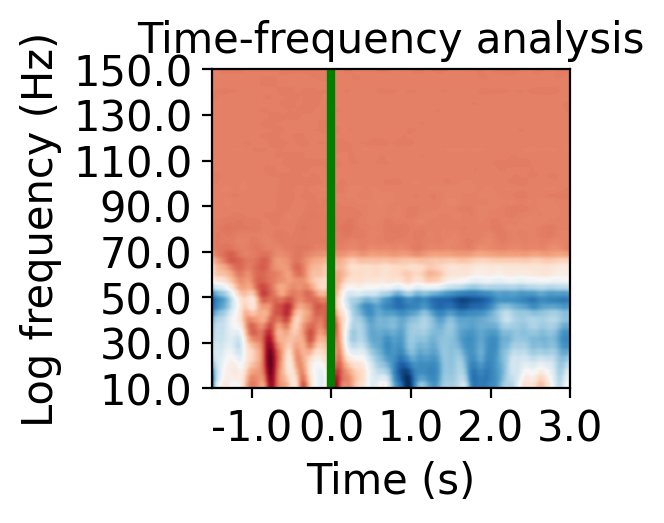

In [83]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(3, 2.5), dpi=200)
fig.patch.set_alpha(0)
axs.patch.set_alpha(0)
axs.imshow(power_rescale, extent=extent, aspect="auto", 
        origin="lower", cmap='RdBu_r')

axs.set_xticks(np.linspace(0.5, 4.5, 5))
axs.set_xticklabels(np.linspace(-1, 3, 5), fontsize=15)
axs.set_yticks(np.linspace(10, 150, 8))
axs.set_yticklabels(np.round(np.linspace(10, 150, 8), decimals=1), fontsize=15)
axs.set_xlabel('Time (s)', fontsize=15)
axs.set_ylabel('Log frequency (Hz)', fontsize=15)
axs.set_title("Time-frequency analysis", fontsize=15)
axs.axvline(1.5, color='g', linewidth=3)
axs.set_xlim(0, 4.5)
plt.plot();
#plt.savefig("../plots/fig4a1.svg", format = 'svg', dpi=200);


In [19]:
power_rescale_ = np.zeros((elec_mat.shape[0], 49, elec_mat.shape[1]))


tf_mat = np.expand_dims(elec_mat, axis=1)
for item in range(elec_mat.shape[0]):

    tf_mat_use = np.expand_dims(tf_mat[item], axis=1)

    tf_mat_use = mne.EpochsArray(tf_mat_use, mne.create_info([f'{chanlabel}'], 1000))
    freqs = np.logspace(*np.log10([10, 150]), num=49)
    n_cycles = freqs / 2.
    power, itc = tfr_morlet(tf_mat_use, freqs=freqs, n_cycles=n_cycles, picks='all')
    times = np.linspace(0, 5, 5000)
    extent = (times[0], times[-1], freqs[0], freqs[-1])
    power_rescaled = mne.baseline.rescale(power.data[0], tf_mat_use.times, (0.5, 1))
    power_rescale_[item] = power_rescaled
    

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [20]:
xvals = np.linspace(-1.5, 3.5, 5000)


In [21]:
power_rescale_sig = np.zeros((49, 5000))

for item in range(power_rescale_.shape[1]):
    print(item)
    power_rescale_use = power_rescale_[:, item]
    power_rescale_rest = power_rescale_use[:, :1000]
    rest_mean = power_rescale_rest.mean()
    rest_std = np.std(power_rescale_rest)
    rest_sem = rest_std/np.sqrt(power_rescale_rest.shape[0])
    FR_compare = np.random.randn(100, 5000)*rest_std+rest_mean
    
    significance = pd.DataFrame({"xvals":xvals, 
                                     "pval":f_oneway(power_rescale_use, FR_compare).pvalue})
    for i2 in range(len(xvals)):
        if multitest.fdrcorrection(significance.pval)[0][i2] == True:
            #if power_rescale_use[item, i2] < rest_mean:
            power_rescale_sig[item, i2] = 1000

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


NameError: name 'fig' is not defined

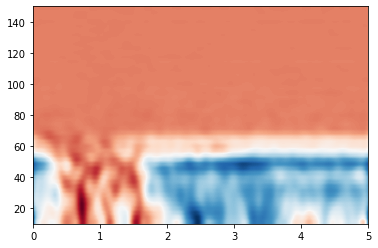

In [22]:
im1 = plt.imshow(power_rescale, extent=extent, aspect="auto", 
        origin="lower", cmap='RdBu_r')


fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
cb = fig.colorbar(im1, cax=cbar_ax)
cbar_ax.tick_params(labelsize=10)
cb.outline.set_linewidth(0)


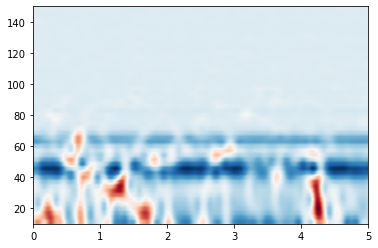

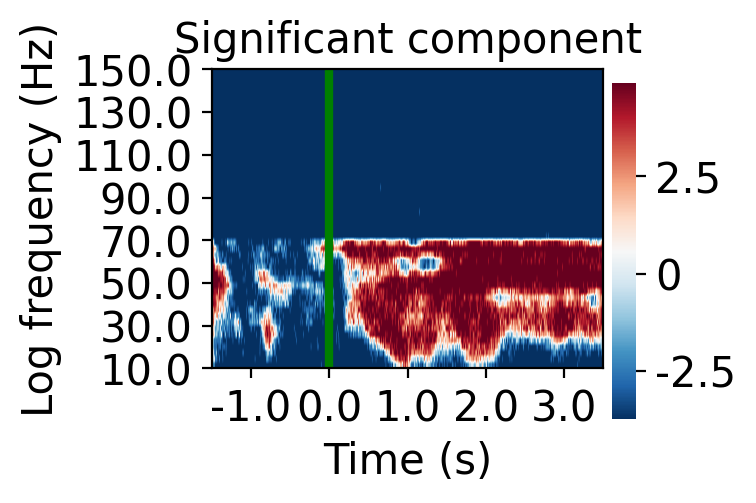

In [76]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(3, 2.4), dpi=200)
axs.patch.set_alpha(0)

axs.imshow(power_rescale_sig, extent=extent, aspect="auto", 
        origin="lower", cmap='RdBu_r', vmin=0)
axs.set_xticks(np.linspace(0.5, 4.5, 5))
axs.set_xticklabels(np.linspace(-1, 3, 5), fontsize=15)
axs.set_yticks(np.linspace(10, 150, 8))
axs.set_yticklabels(np.round(np.linspace(10, 150, 8), decimals=1), fontsize=15)
axs.set_xlabel('Time (s)', fontsize=15)
axs.set_ylabel('Log frequency (Hz)', fontsize=15)
axs.set_title("Significant component", fontsize=15)
axs.axvline(1.5, color='g', linewidth=3)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1, 0.15, 0.04, 0.7])
cb = fig.colorbar(im1, cax=cbar_ax)
cbar_ax.tick_params(labelsize=15)
cb.outline.set_linewidth(0)
cb.set_ticks((-25000, 0, 25000))
cb.set_ticklabels([-2.5, 0, 2.5])
plt.plot();
#plt.savefig("../plots/fig4b.svg", format = 'svg', dpi=200);
#plt.close(fig);

In [92]:
power_rescale.shape
np.linspace(-1, 3, 5)
np.linspace(0, 4, 5)

(49, 5000)

array([-1.,  0.,  1.,  2.,  3.])

array([0., 1., 2., 3., 4.])

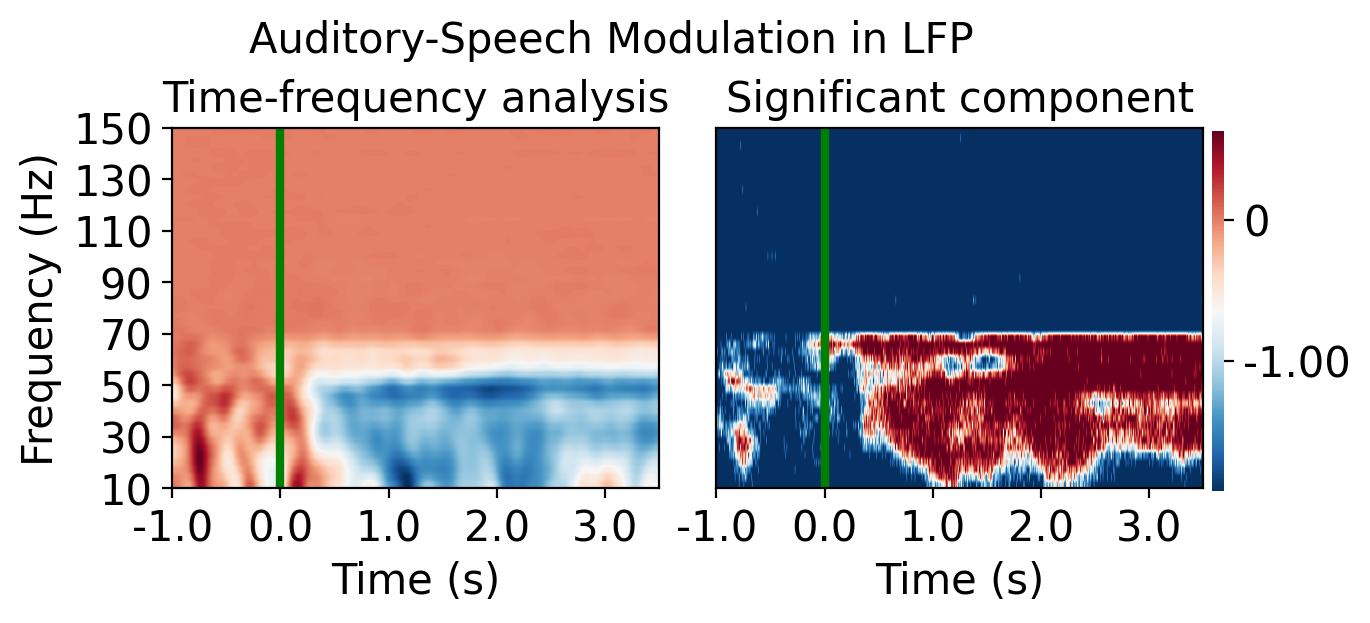

In [30]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 3), dpi=200)
fig.patch.set_alpha(0)
axs[0].patch.set_alpha(0)
axs[0].imshow(power_rescale[:, 500:], extent=extent, aspect="auto", 
        origin="lower", cmap='RdBu_r')

axs[0].set_xticks(np.linspace(0, 4, 5))
axs[0].set_xticklabels(np.linspace(-1, 3, 5), fontsize=15)
axs[0].set_yticks(np.linspace(10, 150, 8))
axs[0].set_yticklabels(np.linspace(10, 150, 8, dtype=int), fontsize=15)
axs[0].set_xlabel('Time (s)', fontsize=15)
axs[0].set_ylabel('Frequency (Hz)', fontsize=15)
axs[0].set_title("Time-frequency analysis", fontsize=15)
axs[0].axvline(1, color='g', linewidth=3)
axs[0].set_xlim(0, 4.5)


axs[1].patch.set_alpha(0)

axs[1].imshow(power_rescale_sig[:, 500:], extent=extent, aspect="auto", 
        origin="lower", cmap='RdBu_r')
axs[1].set_xticks(np.linspace(0, 4, 5))
axs[1].set_xticklabels(np.linspace(-1, 3, 5), fontsize=15)
axs[1].set_yticks([])
axs[1].set_yticklabels([])
axs[1].set_xlabel('Time (s)', fontsize=15)
#axs[1].set_ylabel('Log frequency (Hz)', fontsize=15)
axs[1].set_title("Significant component", fontsize=15)
axs[1].axvline(1, color='g', linewidth=3)
#fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([1, 0.2, 0.01, 0.6])
cb = fig.colorbar(im1, cax=cbar_ax)
cbar_ax.tick_params(labelsize=15)
cb.outline.set_linewidth(0)
cb.set_ticks((-10000, 0))
cb.set_ticklabels(['-1.00', 0])
axs[1].set_xlim(0, 4.5)

plt.suptitle('Auditory-Speech Modulation in LFP', fontsize=15)
plt.plot();


In [25]:
elec_mat_1 = elec_mat

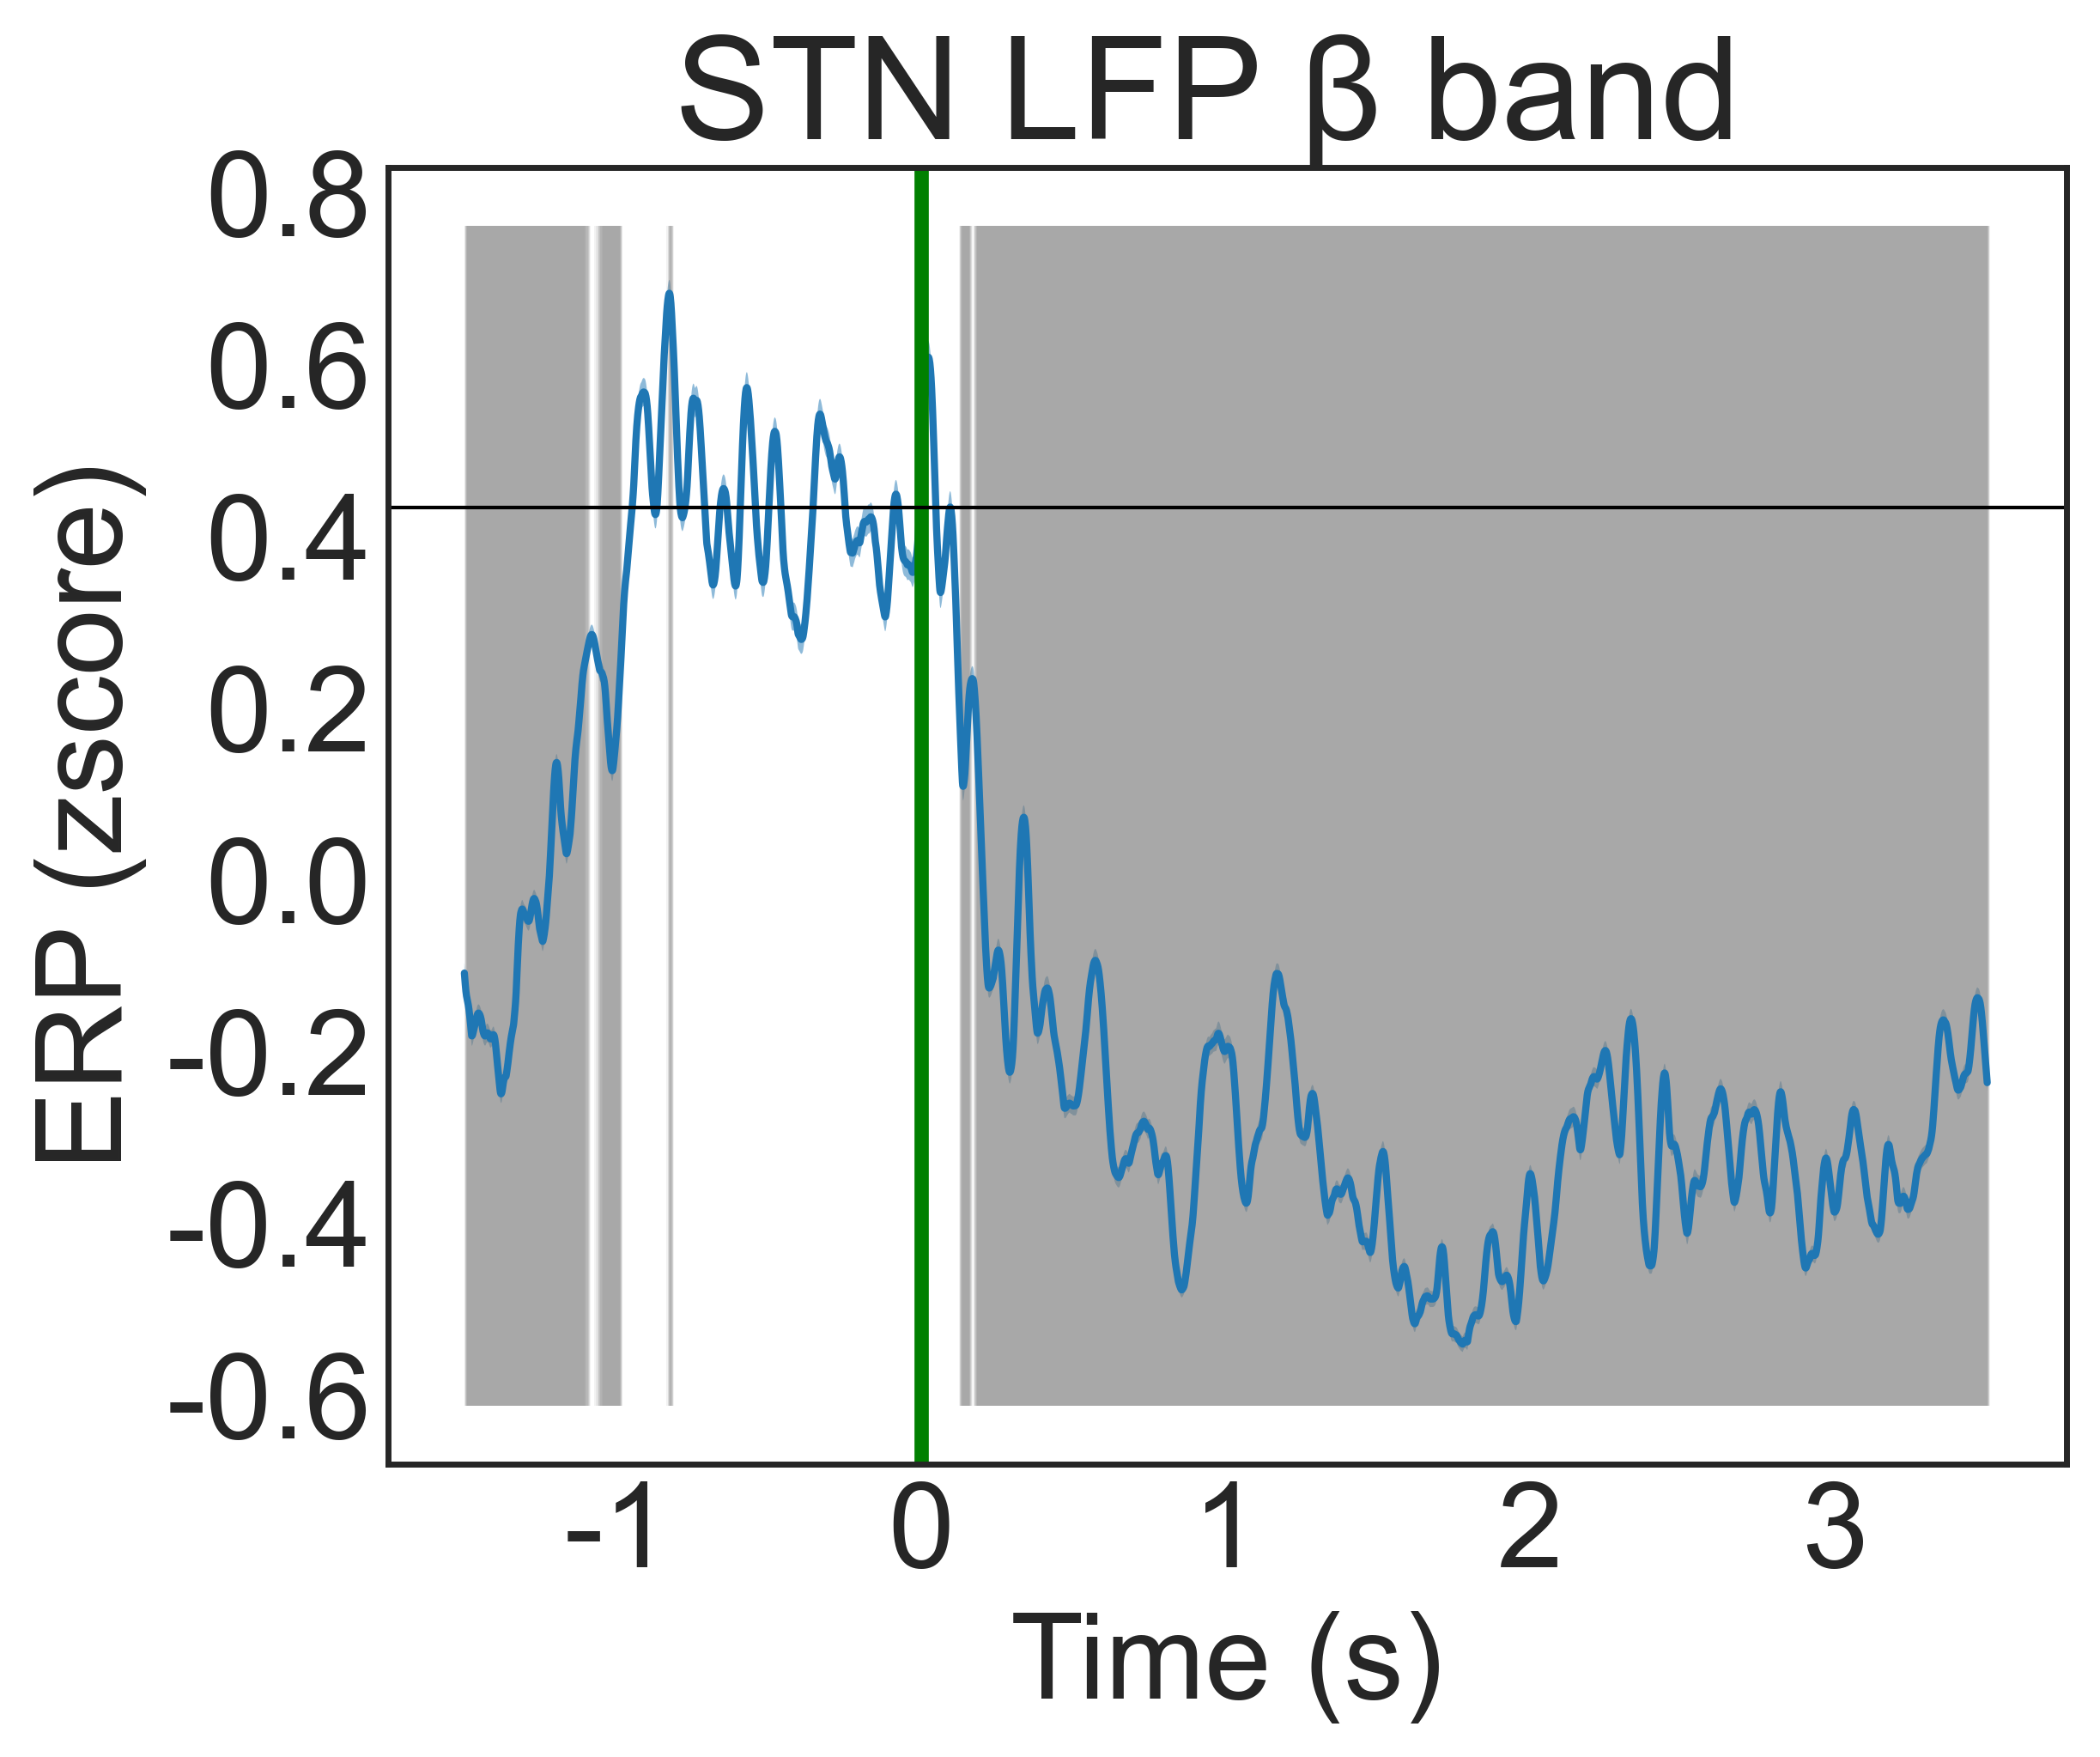

In [28]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 5), dpi=200)
axs.patch.set_alpha(0)

elec_mat_mean = np.nanmean(elec_mat_1, axis=0)
elec_mat_sem = nansem(elec_mat_1)

axs.plot(xvals, elec_mat_mean)
axs.fill_between(xvals, elec_mat_mean-elec_mat_sem, elec_mat_mean+elec_mat_sem, alpha=0.5)
axs.set_title(f"STN LFP β band ", fontsize=30)
FR_mean = elec_mat_mean[500:1500].mean()
FR_std = np.nanstd(elec_mat_mean[500:1500])
FR_compare = FR_std * np.random.randn(100, 5000) + FR_mean

axs.axvline(0, color='g', linewidth=3)
axs.axhline(FR_mean, color='k', linewidth=0.75, label='Mean ERP amplitude')
axs.set_ylabel('ERP (zscore)', fontsize=25)
axs.set_xlabel('Time (s)', fontsize=25)

significance = pd.DataFrame({"xvals":xvals, 
                             "pval":f_oneway(elec_mat_1, FR_compare).pvalue})
patch_y = axs.get_ylim()[1] - axs.get_ylim()[0]
for item in range(len(xvals)):
    if multitest.fdrcorrection(significance.pval)[0][item] == True:
        axs.add_patch(mpatches.Rectangle((item/1000-1.5, 
                                                   axs.get_ylim()[0]), 
                                                  0.01, patch_y, color='grey', 
                                                  alpha=0.1, ec=None))
        
axs.set_xticklabels(axs.get_xticks().astype(int), fontsize=25)
axs.set_yticklabels([round(item, 2) for item in axs.get_yticks()], fontsize=25)
plt.plot();

In [27]:

print(i2)
SUBJECT = "DBS3027"
elec = 1

f_range = (13, 30)
#file_path = f'..\..\..\DBS\\{SUBJECT}\Preprocessed Data\FieldTrip'
#subj_mat = hdf5storage.loadmat(f"{file_path}\\{SUBJECT}_ft_raw_filt_trial_denoised.mat")['D'][0]
file_path = f'../../../DBS/{SUBJECT}/Preprocessed Data/FieldTrip'
subj_mat = hdf5storage.loadmat(f"{file_path}/{SUBJECT}_ft_raw_filt_trial_denoised.mat")['D'][0]

chanlabel = []
for item in range(subj_mat['label'].shape[0]):
    chanlabel.append(subj_mat['label'][item][0][0][0])
chanlabel = np.array(chanlabel)

fs = subj_mat['fsample'][0][0]
nChans = len(subj_mat['label'])
nTrials = len(subj_mat['trial'][0])

dbs_chan = []
for item in range(nChans):
    if chanlabel[item][:4] == "dbs_":
        dbs_chan.append(item)

time_mat = subj_mat['time'][0]
trial_mat = subj_mat['trial'][0]

subject_table = produced_df[produced_df.subject == SUBJECT].reset_index(drop=1)
subject_table = find_full_3_trial2(subject_table).reset_index(drop=1)
subject_table = subject_table[subject_table.syl_id == 1].reset_index(drop=1)

#cue_df = pd.read_csv(f'Z:\DBS\\{SUBJECT}\Preprocessed Data\Sync\\annot\\{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{SUBJECT}/Preprocessed Data/Sync/annot/{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
subj_df_cue = pd.merge(subject_table, cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

ecog_mat = np.zeros((subj_df_cue.shape[0], 5000))

for item in range(subj_df_cue.shape[0]):
    time_point = subj_df_cue.iloc[item].starts_y
    for i2 in range(nTrials):
        time_min = time_mat[i2][0].min()
        time_max = time_mat[i2][0].max()
        if (time_point < time_max - 3.5) and (time_point > time_min + 1.5):
            for i3 in range(len(time_mat[i2][0])):
                if time_mat[i2][0][i3] > time_point:
                    if len(dbs_chan)> 0:
                        sig_filt = trial_mat[i2][dbs_chan][elec]
                        sig_filt = filter_signal(sig_filt, fs, 'bandpass', f_range)
                        sig_filt = np.nan_to_num(sig_filt)
                        analytic_signal = hilbert(sig_filt)
                        amplitude_envelope = np.abs(analytic_signal)
                        ecog_mat[item] = amplitude_envelope[i3-1500:i3+3500]


                    break
                    break

elec_mat = ecog_mat[~np.all(ecog_mat == 0, axis=1)]
elec_mat = get_zscore(elec_mat)
#elec_mat = np.nanmean(elec_mat, axis=0)
elec_mat_2 = elec_mat

357


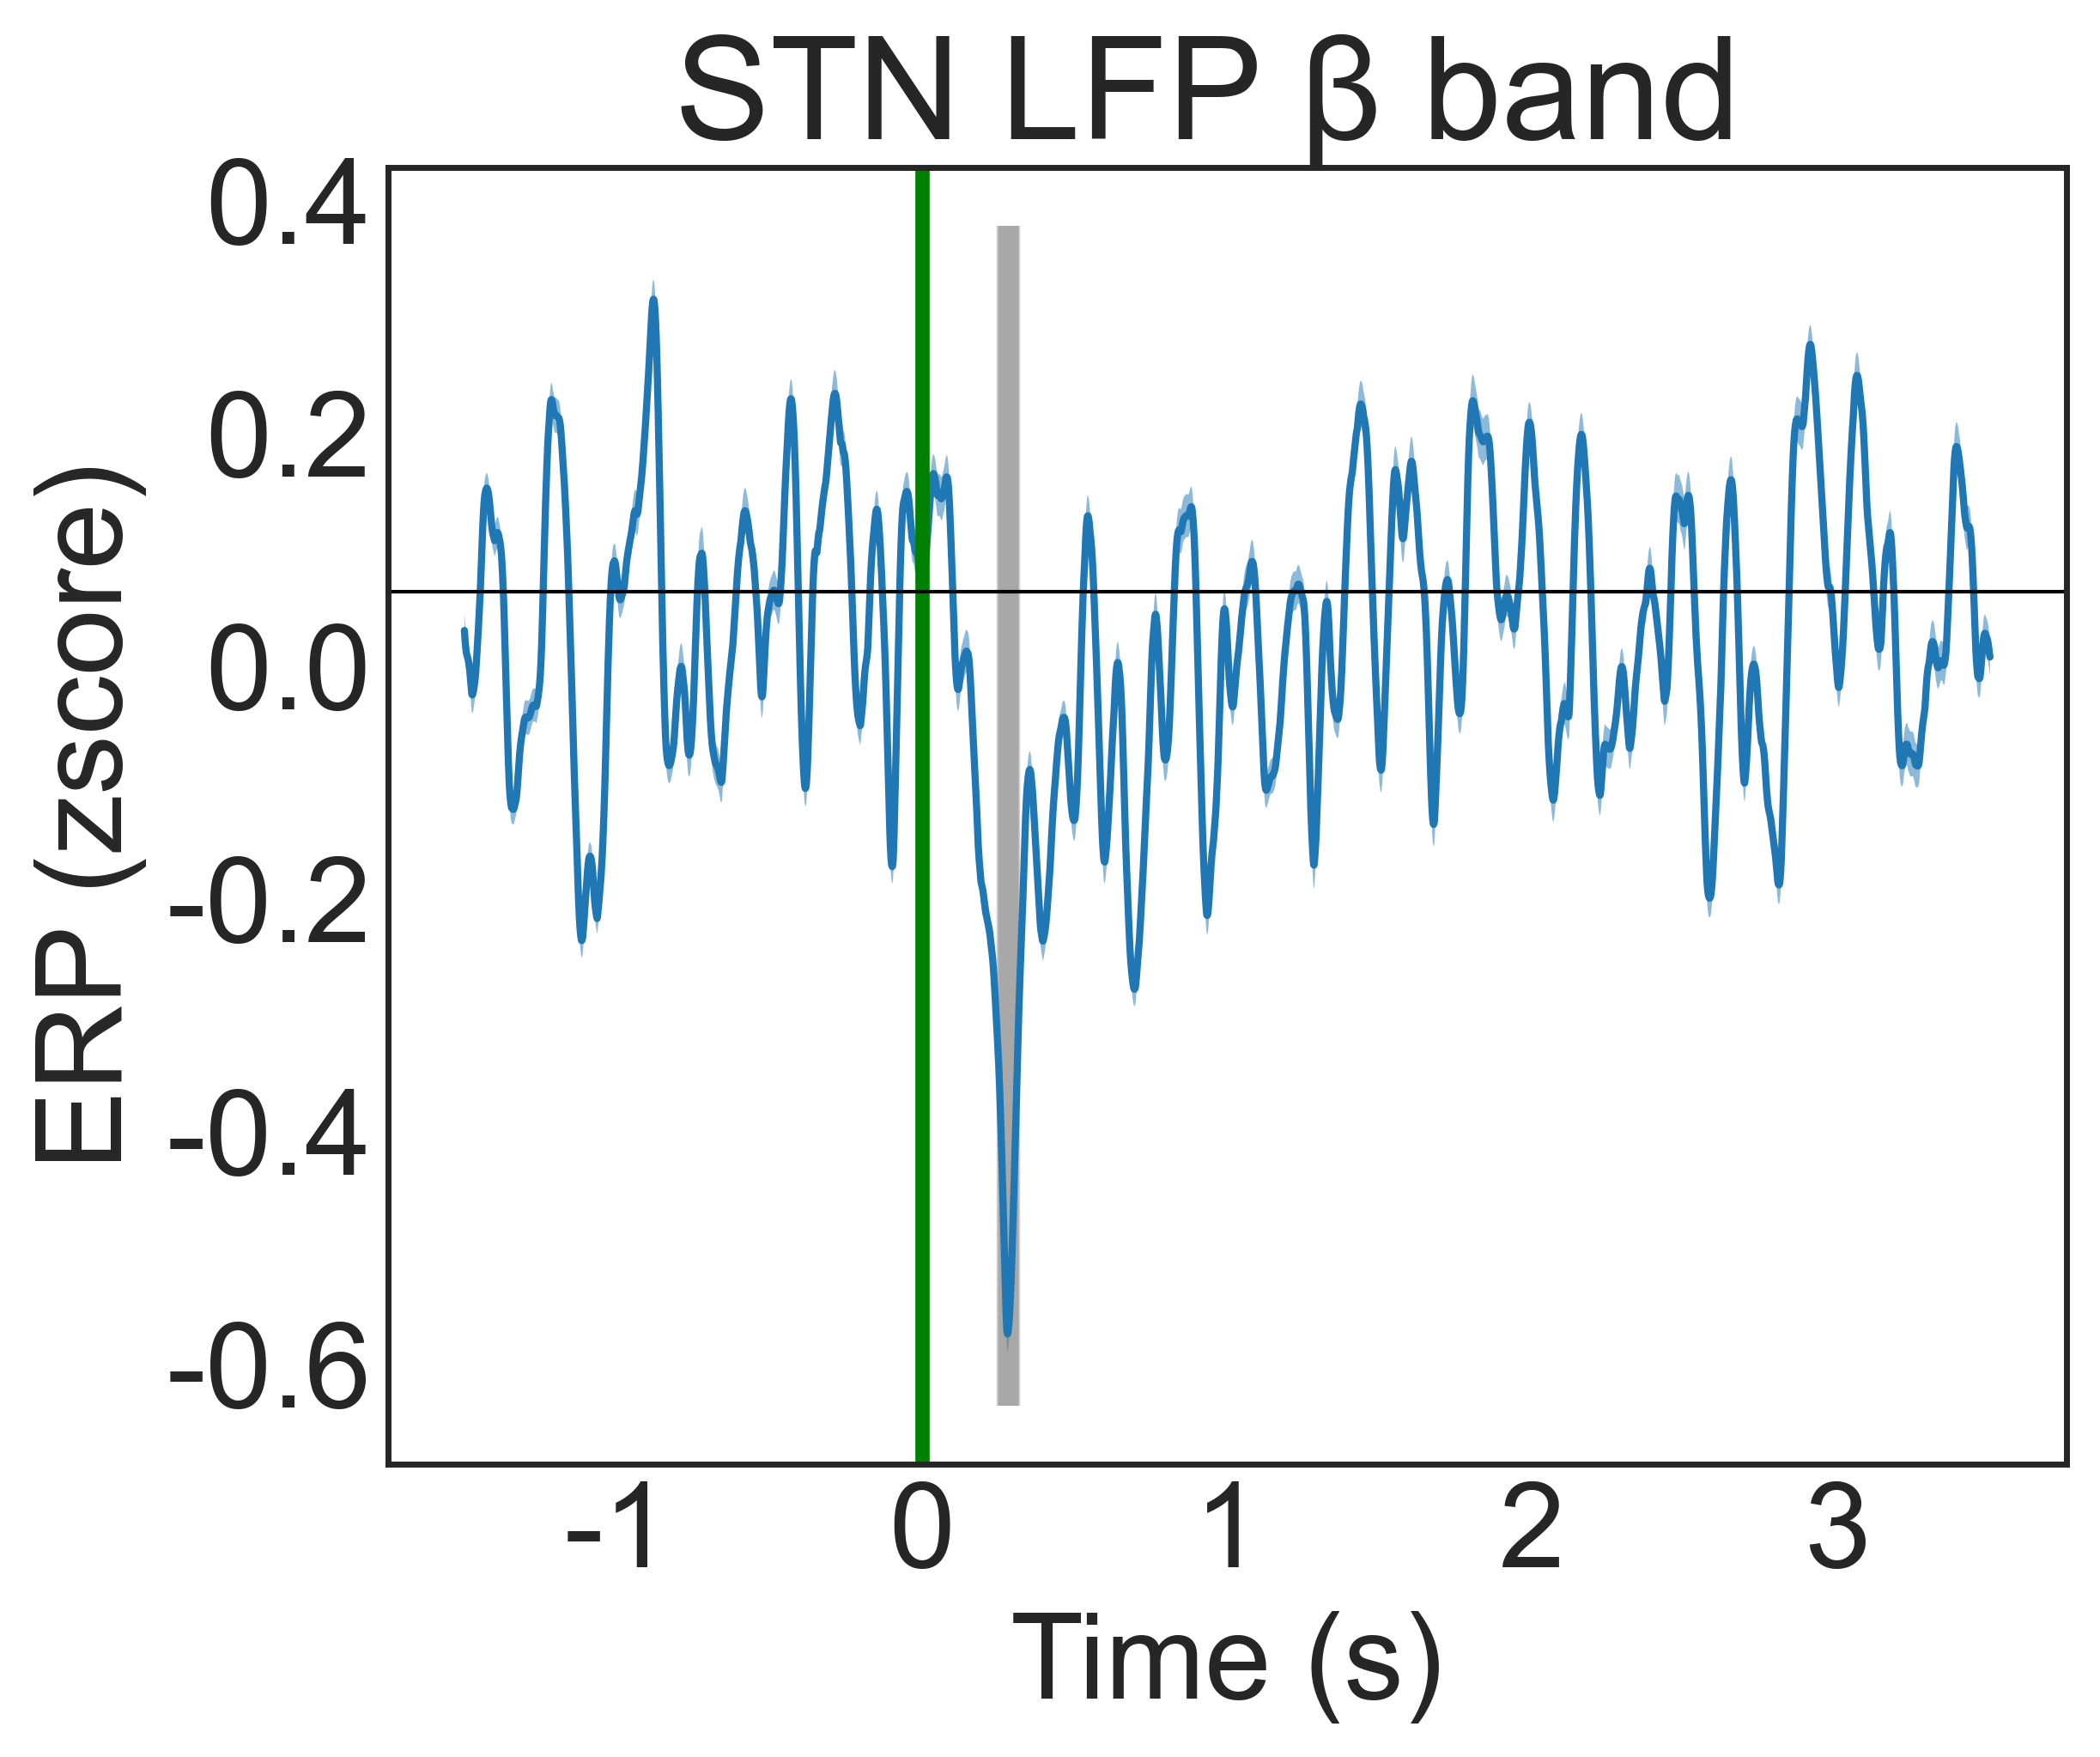

In [29]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 5), dpi=200)
axs.patch.set_alpha(0)

elec_mat_mean = np.nanmean(elec_mat_2, axis=0)
elec_mat_sem = nansem(elec_mat_2)
axs.plot(xvals, elec_mat_mean)
axs.fill_between(xvals, elec_mat_mean-elec_mat_sem, elec_mat_mean+elec_mat_sem, alpha=0.5)
axs.set_title(f"STN LFP β band ", fontsize=30)
FR_mean = elec_mat_mean[500:1500].mean()
FR_std = np.nanstd(elec_mat_mean[500:1500])
FR_compare = FR_std * np.random.randn(100, 5000) + FR_mean

axs.axvline(0, color='g', linewidth=3)
axs.axhline(FR_mean, color='k', linewidth=0.75, label='Mean ERP amplitude')
axs.set_ylabel('ERP (zscore)', fontsize=25)
axs.set_xlabel('Time (s)', fontsize=25)

significance = pd.DataFrame({"xvals":xvals, 
                             "pval":f_oneway(elec_mat_2, FR_compare).pvalue})
patch_y = axs.get_ylim()[1] - axs.get_ylim()[0]
for item in range(len(xvals)):
    if multitest.fdrcorrection(significance.pval)[0][item] == True:
        axs.add_patch(mpatches.Rectangle((item/1000-1.5, 
                                                   axs.get_ylim()[0]), 
                                                  0.01, patch_y, color='grey', 
                                                  alpha=0.1, ec=None))
        
axs.set_xticklabels(axs.get_xticks().astype(int), fontsize=25)
axs.set_yticklabels([round(item, 2) for item in axs.get_yticks()], fontsize=25)
plt.plot();

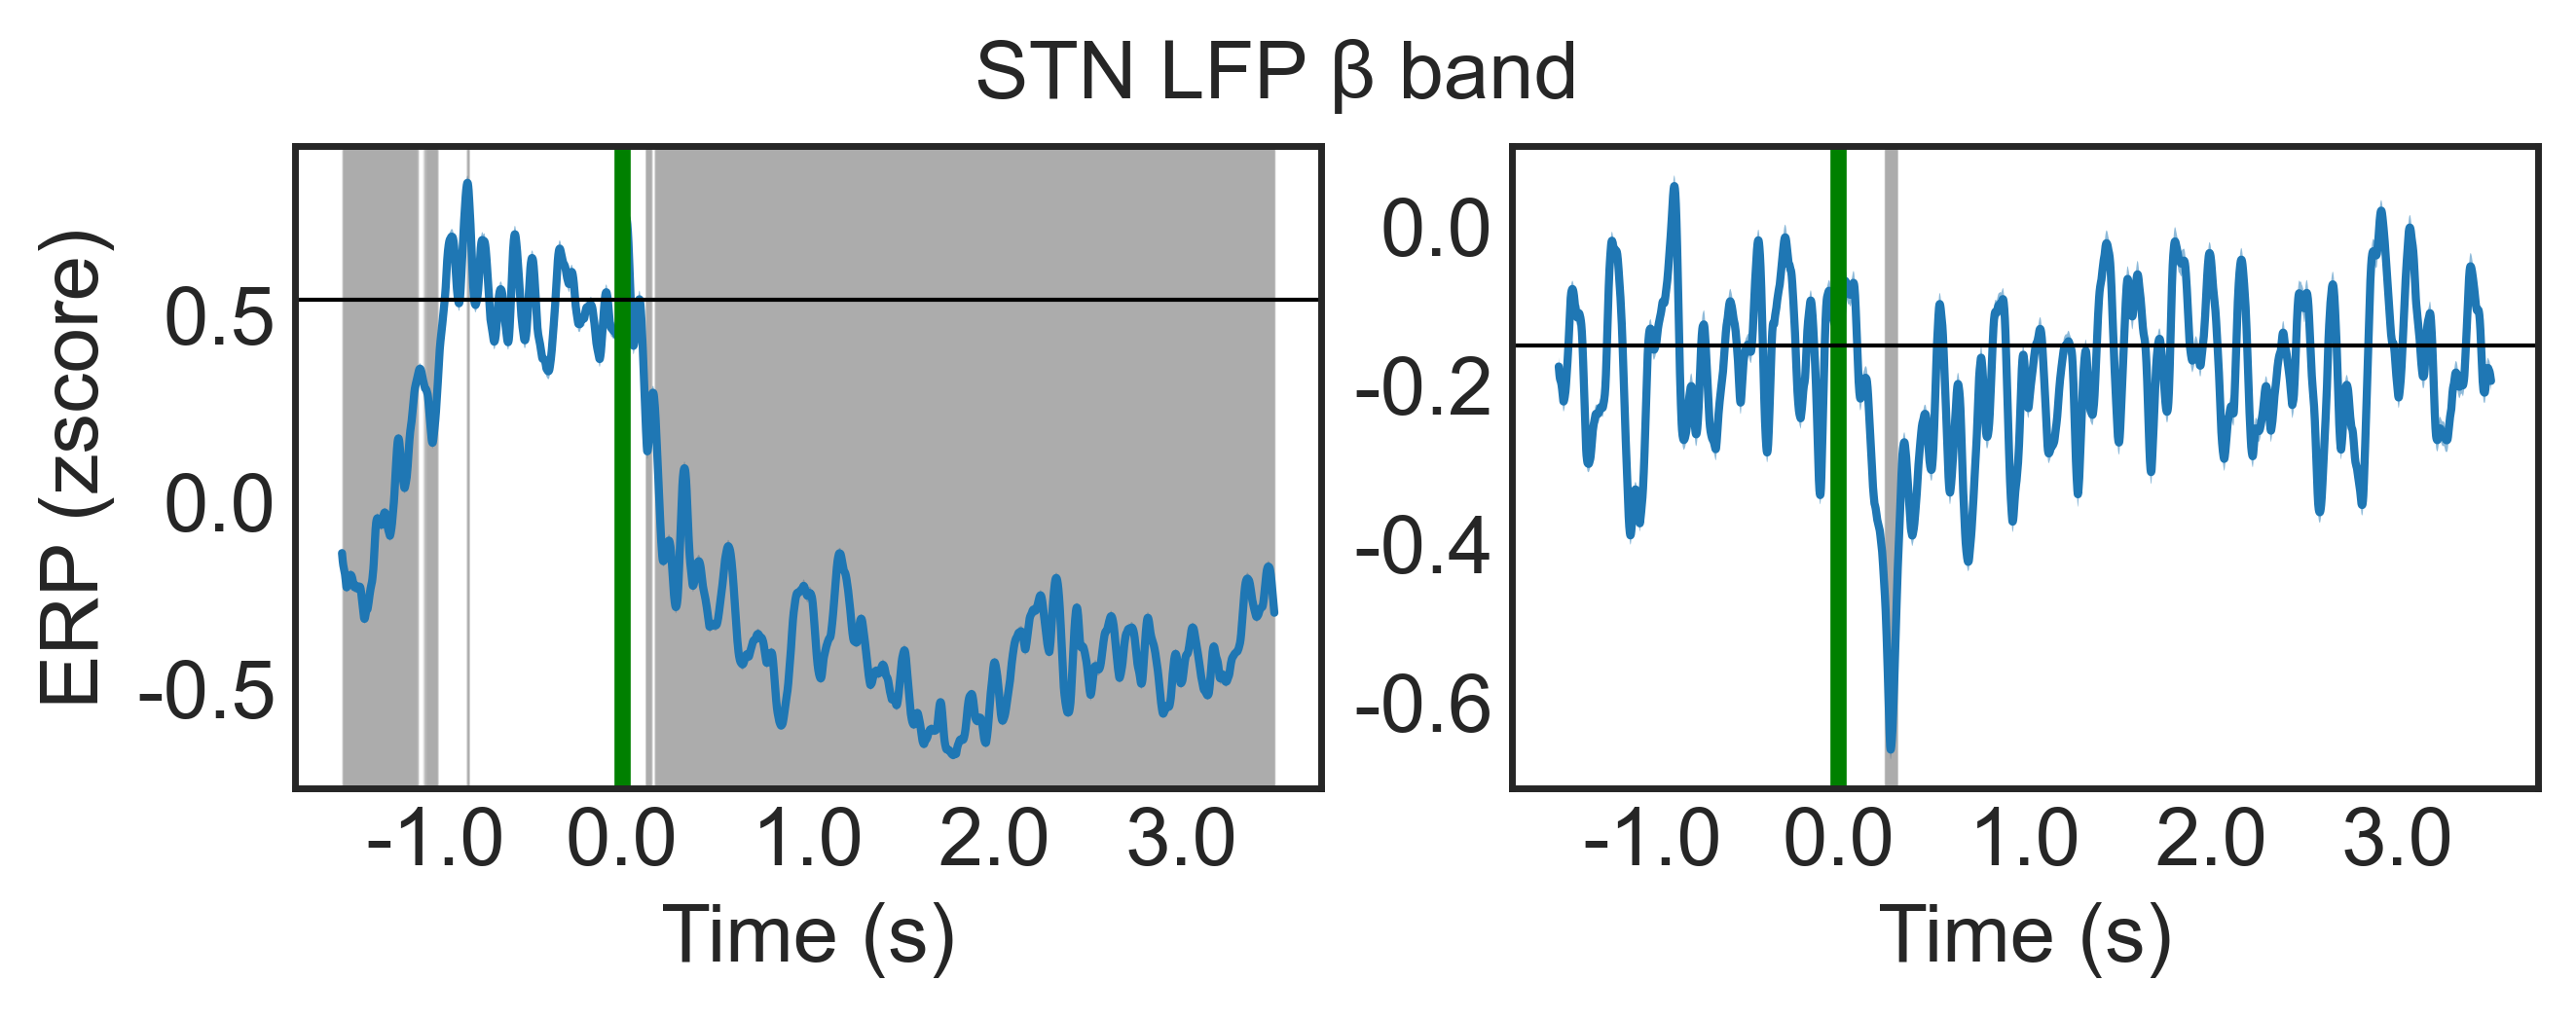

In [47]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(6.5, 2.5), dpi=200)


fig.patch.set_alpha(0)
axs[0].patch.set_alpha(0)
axs[1].patch.set_alpha(0)

elec_mat_mean = np.nanmean(elec_mat_1, axis=0)
elec_mat_sem = nansem(elec_mat_1)

axs[0].plot(xvals, elec_mat_mean)
axs[0].fill_between(xvals, elec_mat_mean-elec_mat_sem, elec_mat_mean+elec_mat_sem, alpha=0.5)
FR_mean = elec_mat_mean[500:1500].mean()
FR_std = np.nanstd(elec_mat_mean[500:1500])
FR_compare = FR_std * np.random.randn(100, 5000) + FR_mean

axs[0].axvline(0, color='g', linewidth=3)
axs[0].axhline(FR_mean, color='k', linewidth=0.75, label='Mean ERP amplitude')
axs[0].set_ylabel('ERP (zscore)', fontsize=15)
axs[0].set_xlabel('Time (s)', fontsize=15)

significance = pd.DataFrame({"xvals":xvals, 
                             "pval":f_oneway(elec_mat_1, FR_compare).pvalue})
patch_y = axs[0].get_ylim()[1] - axs[0].get_ylim()[0]
for item in range(len(xvals)):
    if multitest.fdrcorrection(significance.pval)[0][item] == True:
        axs[0].add_patch(mpatches.Rectangle((item/1000-1.5, 
                                                   axs[0].get_ylim()[0]), 
                                                  0.01, patch_y, color='grey', 
                                                  alpha=0.1, ec=None))
        
#axs[0].set_xticklabels([round(item, 2) for item in axs[0].get_xticks()], fontsize=15)
axs[0].set_xticklabels(np.linspace(-2, 4, 7), fontsize=15)
axs[0].set_yticklabels([round(item, 2) for item in axs[0].get_yticks()], fontsize=15)


elec_mat_mean = np.nanmean(elec_mat_2, axis=0)
elec_mat_sem = nansem(elec_mat_2)
axs[1].plot(xvals, elec_mat_mean)
axs[1].fill_between(xvals, elec_mat_mean-elec_mat_sem, elec_mat_mean+elec_mat_sem, alpha=0.5)
FR_mean = elec_mat_mean[500:1500].mean()
FR_std = np.nanstd(elec_mat_mean[500:1500])
FR_compare = FR_std * np.random.randn(100, 5000) + FR_mean

axs[1].axvline(0, color='g', linewidth=3)
axs[1].axhline(FR_mean, color='k', linewidth=0.75, label='Mean ERP amplitude')
axs[1].set_xlabel('Time (s)', fontsize=15)

significance = pd.DataFrame({"xvals":xvals, 
                             "pval":f_oneway(elec_mat_2, FR_compare).pvalue})
patch_y = axs[1].get_ylim()[1] - axs[1].get_ylim()[0]
for item in range(len(xvals)):
    if multitest.fdrcorrection(significance.pval)[0][item] == True:
        axs[1].add_patch(mpatches.Rectangle((item/1000-1.5, 
                                                   axs[1].get_ylim()[0]), 
                                                  0.01, patch_y, color='grey', 
                                                  alpha=0.1, ec=None))
#axs[1].set_xticklabels([round(item, 2) for item in axs[1].get_xticks()], fontsize=15)
axs[1].set_xticklabels(np.linspace(-2, 4, 7), fontsize=15)
axs[1].set_yticklabels([round(item, 2) for item in axs[1].get_yticks()], fontsize=15)

plt.suptitle(f"STN LFP β band ", fontsize=15)

plt.savefig("../plots/fig4d.svg", format = 'svg', dpi=200);


In [32]:
xvals

array([-1.5      , -1.4989998, -1.4979996, ...,  3.4979996,  3.4989998,
        3.5      ])

In [36]:
[round(item, 2) for item in axs[1].get_xticks()]

[-2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]

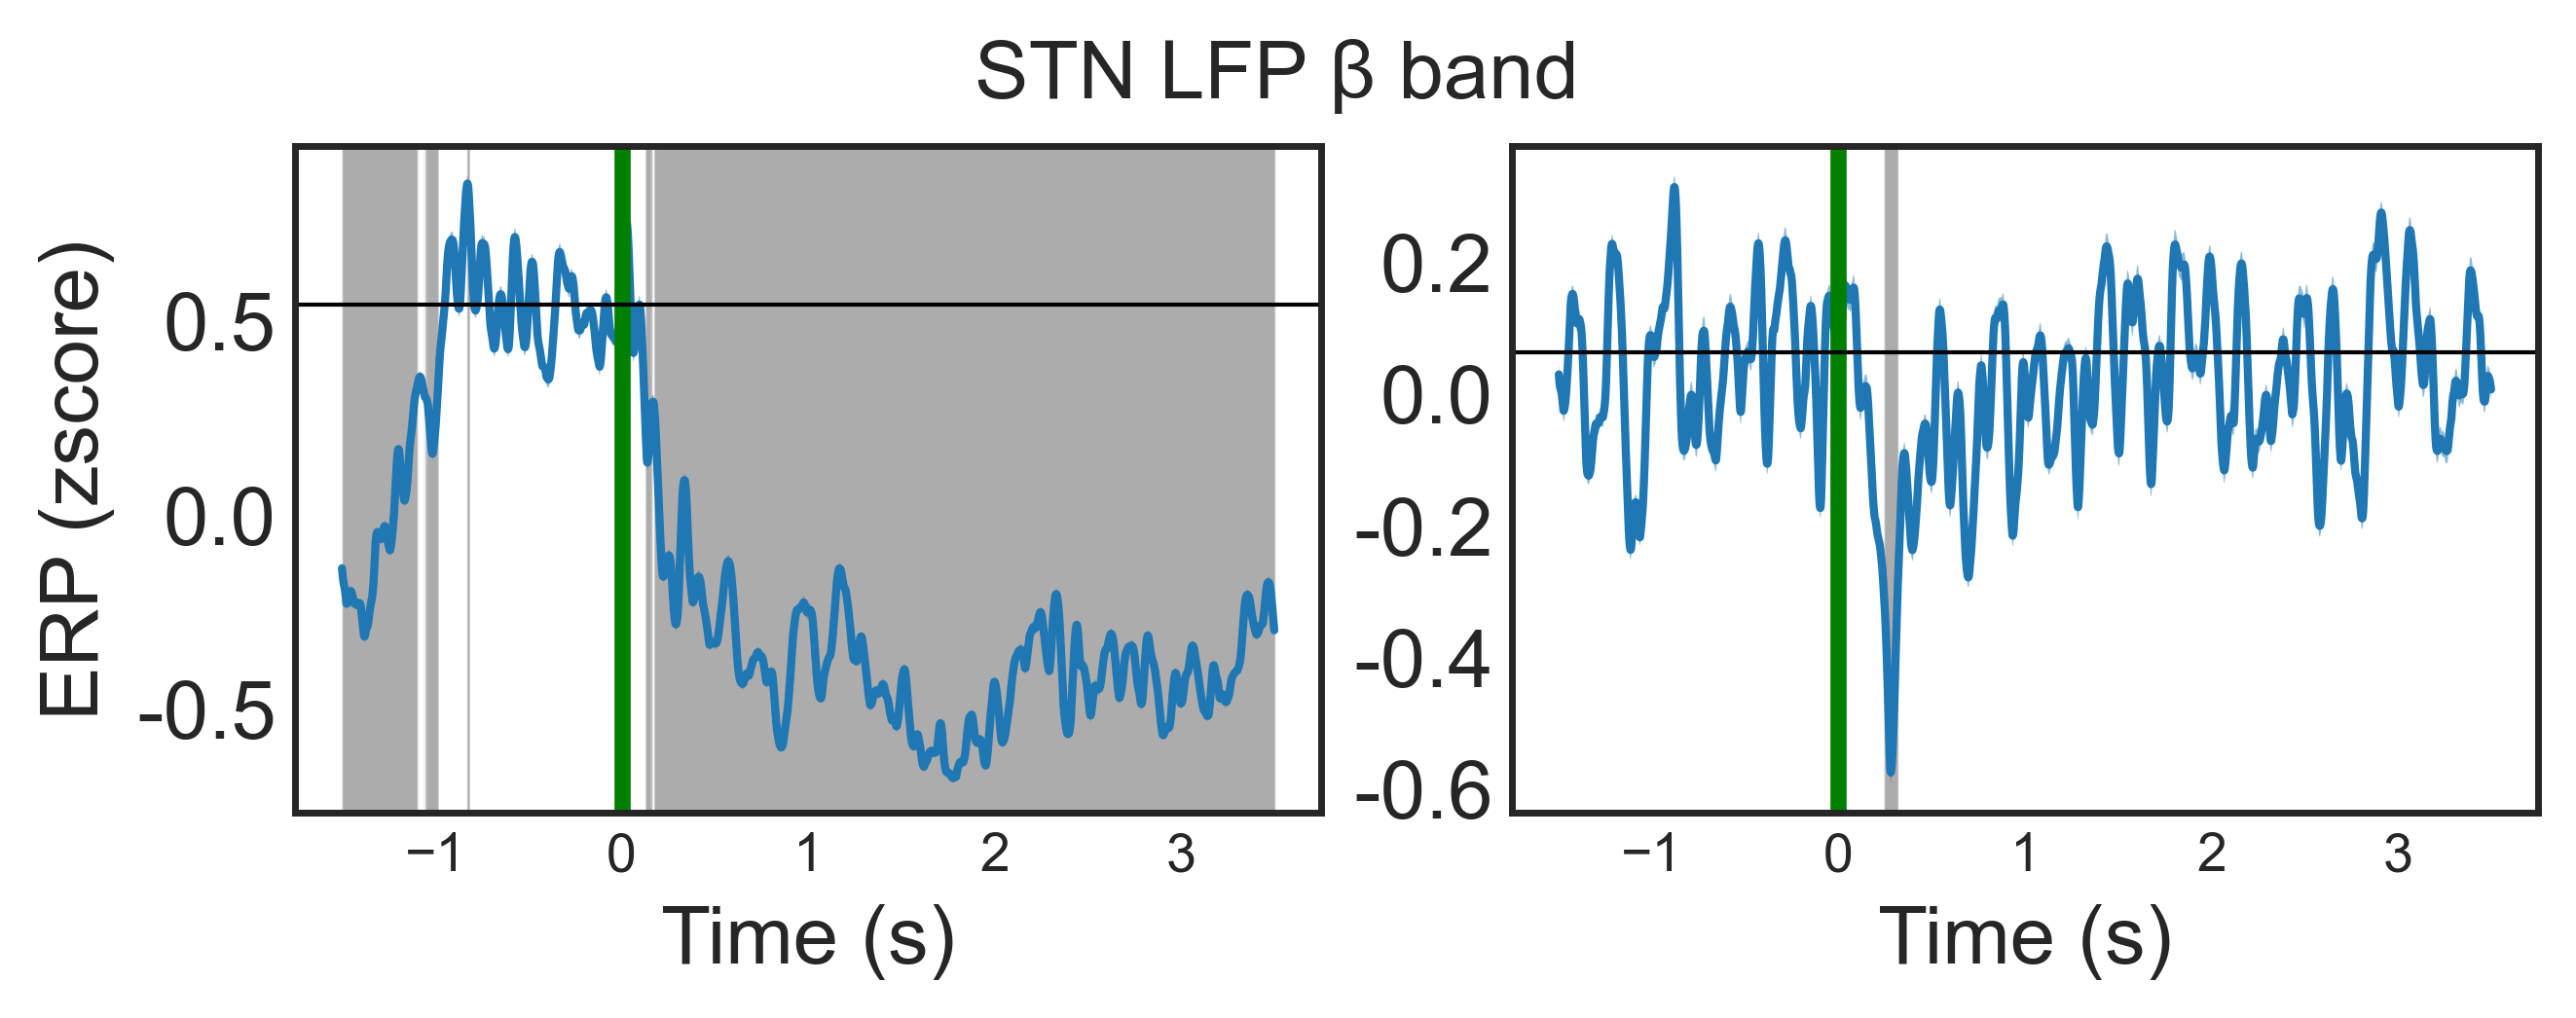

In [43]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(6.5, 2.5), dpi=200)


fig.patch.set_alpha(0)
axs[0].patch.set_alpha(0)
axs[1].patch.set_alpha(0)

elec_mat_mean = np.nanmean(elec_mat_1, axis=0)
elec_mat_sem = nansem(elec_mat_1)

axs[0].plot(xvals, elec_mat_mean)
axs[0].fill_between(xvals, elec_mat_mean-elec_mat_sem, elec_mat_mean+elec_mat_sem, alpha=0.5)
FR_mean = elec_mat_mean[500:1500].mean()
FR_std = np.nanstd(elec_mat_mean[500:1500])
FR_compare = FR_std * np.random.randn(100, 5000) + FR_mean

axs[0].axvline(0, color='g', linewidth=3)
axs[0].axhline(FR_mean, color='k', linewidth=0.75, label='Mean ERP amplitude')
axs[0].set_ylabel('ERP (zscore)', fontsize=15)
axs[0].set_xlabel('Time (s)', fontsize=15)

significance = pd.DataFrame({"xvals":xvals, 
                             "pval":f_oneway(elec_mat_1, FR_compare).pvalue})
patch_y = axs[0].get_ylim()[1] - axs[0].get_ylim()[0]
for item in range(len(xvals)):
    if multitest.fdrcorrection(significance.pval)[0][item] == True:
        axs[0].add_patch(mpatches.Rectangle((item/1000-1.5, 
                                                   axs[0].get_ylim()[0]), 
                                                  0.01, patch_y, color='grey', 
                                                  alpha=0.1, ec=None))
        
#axs[0].set_xticklabels([round(item, 2) for item in axs[0].get_xticks()], fontsize=15)
axs[0].set_yticklabels([round(item, 2) for item in axs[0].get_yticks()], fontsize=15)


elec_mat_mean = np.nanmean(elec_mat_2, axis=0)
elec_mat_sem = nansem(elec_mat_2)
axs[1].plot(xvals, elec_mat_mean)
axs[1].fill_between(xvals, elec_mat_mean-elec_mat_sem, elec_mat_mean+elec_mat_sem, alpha=0.5)
FR_mean = elec_mat_mean[500:1500].mean()
FR_std = np.nanstd(elec_mat_mean[500:1500])
FR_compare = FR_std * np.random.randn(100, 5000) + FR_mean

axs[1].axvline(0, color='g', linewidth=3)
axs[1].axhline(FR_mean, color='k', linewidth=0.75, label='Mean ERP amplitude')
axs[1].set_xlabel('Time (s)', fontsize=15)

significance = pd.DataFrame({"xvals":xvals, 
                             "pval":f_oneway(elec_mat_2, FR_compare).pvalue})
patch_y = axs[1].get_ylim()[1] - axs[1].get_ylim()[0]
for item in range(len(xvals)):
    if multitest.fdrcorrection(significance.pval)[0][item] == True:
        axs[1].add_patch(mpatches.Rectangle((item/1000-1.5, 
                                                   axs[1].get_ylim()[0]), 
                                                  0.01, patch_y, color='grey', 
                                                  alpha=0.1, ec=None))
#axs[1].set_xticklabels([round(item, 2) for item in axs[1].get_xticks()], fontsize=15)
#axs[1].set_xticklabels(np.linspace(-1, 3, 5), fontsize=15)
axs[1].set_yticklabels([round(item, 2) for item in axs[1].get_yticks()], fontsize=15)

plt.suptitle(f"STN LFP β band ", fontsize=15)

plt.show();